# Notebook for analyzing Krt17 Expression over HT and across genetic perturbations

###### Ethan Earlie ... 2/10/2025

## Import Jobs

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
#import cellrank as cr
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc

import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib
from matplotlib import rcParams
from adjustText import adjust_text

from scipy.stats import zscore
from copy import deepcopy
from kneed.knee_locator import KneeLocator
from sklearn.metrics.cluster import adjusted_rand_score
#from py_pcha.PCHA import PCHA
from skimage import filters
from scipy import stats

#import palantir
import scipy
import sys
import os
import glob
import anndata
import itertools
import phenograph
import sklearn
#import scikit_posthocs
import time

from os import path
from pathlib import Path
from scipy.ndimage.filters import convolve
from statsmodels.nonparametric.smoothers_lowess import lowess

In [57]:
output_dir_base = '/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/'
output_dir = output_dir_base
git_dir = '/workdir/analysis_pipeline/'
!mkdir -p {output_dir_base}
print(f'output_dir: {output_dir_base}')
print(f'git_dir: {git_dir}')
run_in_background_wait_default=True

output_dir: /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/
git_dir: /workdir/analysis_pipeline/


In [206]:
boolean_to_color = {True:'crimson',False:'steelblue'}

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_result { max-width:85% !important; }</style>"))

In [55]:
%matplotlib inline

sc.settings.figdir = output_dir_base
sc.set_figure_params(dpi=80, dpi_save=300)

matplotlib.style.use('default')
sns.set_style('white')

#cr.settings.verbosity = 2
plt.rcParams['figure.figsize']=(6,4) #rescale figures
sc.settings.verbosity = 4

In [54]:
# Helper function for flattening nested lists:
def flatten(l):
    if all(isinstance(x, list) for x in l):
        return [item for sublist in l for item in sublist]
    elif all(isinstance(x, np.ndarray) for x in l):
        return [item for sublist in l for item in sublist]
    else:
        return l
    
    
# Helper function for a quick look at variable distributions:
def stratify(adata, var1, var2, normalize=False):
    for x in sorted(adata.obs[var1].unique()):
        print(x)
        print(adata[adata.obs[var1] == x].obs[var2].value_counts(normalize=normalize))
        print('\n', '#########################', '\n')
    
    
# run bash command in background if stdoutfile does not exist. If it does, output contents of stdoutfile.
# If force=true, overwrite and re-run command.
def run_in_background(command, stdoutfile, stderrfile="", force=False, quiet=False, 
                      wait=run_in_background_wait_default):
    if force or not path.exists(stdoutfile):
        command = 'bash -c \'' + command + '\' > ' + stdoutfile
        if stderrfile:
            command = command + ' 2>' + stderrfile
        else:
            command = command + ' 2>&1'
        if not wait:
            command = command + ' &'
        print('calling ' + command + '\n')
        os.system(command)
    else:
        wait=True
    if wait:
        if not quiet:
            print("Output from stdout file " + stdoutfile)
            !cat {stdoutfile}
        else:
            print("Output from stdout file " + stdoutfile + " is suppressed")
        if stderrfile and path.exists(stderrfile):
            print("Output from stderr file " + stderrfile)
            !cat {stderrfile}
            

# Helper function for filtering lowly expressed genes
def filter_genes(adata, minCell):
    hasCell = adata.layers['X'] > 0
    numCell = np.array(hasCell.sum(axis=0))
    tooSmall = [i < minCell for i in numCell]
    is_invalid = np.zeros(adata.shape[1], np.bool)
    is_invalid[np.where(tooSmall)[0]] = True
    print(f"Removing {np.sum(is_invalid)} out of {len(is_invalid)} genes with less than {minCell} cells")
    adata.var['n_cells_by_counts'] = numCell
    return is_invalid

In [50]:
def my_run_mast(cond1, cond2, infile=None, data_field='logX', hvg_filter='TRUE', sample_covariate='FALSE', covar_field='sample', cell_filter='FALSE',  
                readonly=False, wait=True, force=False, plot=True, num_cores=30,
                use_filter=None, xlabel_cutoff=0.1, groupName='condition', reverse=False,
                sortBy='scaled_rank_score', quiet=True, mast_outdir=None, outname_str="", num_label=30):

    if use_filter is None:
        filterExt=''
        filterGenes=None
        filterName=''
    else:
        filterExt=use_filter['ext']
        filterGenes=use_filter['genes']
        filterName=' ( ' + use_filter['name'] + ')'
        
    if groupName == 'geneExpression':
        mast_outdir = f'{output_dir}/MAST-geneExp/{cond1}'.replace('cellType ', '_')
        outname = f'{cond1}_geneExp{cond2}_{outname_str}'.replace(' ', '_')
    else:
        if mast_outdir == None:
            mast_outdir = f'{output_dir}/{cond1}_vs_{cond2}/MAST'.replace(' ', '_')
            
    outname=f'{cond1}_vs_{cond2}_{outname_str}'.replace(' ', '_')
            
    stdoutfile=f"{mast_outdir}/stdout{outname_str}.txt"
    outfile = f"{mast_outdir}/{outname}.csv"
    plotfile = f"{mast_outdir}/{outname}{filterExt}.png".replace(' ', '_')
    
    if not readonly:
        if (infile is None):
            print("No infile (h5ad) given! Cannot run MAST.")
            return(None)
        if not path.exists(outfile):
            if not force:
                print(f"{outfile} not found, setting force to True")
            force=True
        !cp {git_dir}/scripts/MAST_new.R /root/scripts/
        cmd=f'mkdir -p "{mast_outdir}"'
        !{cmd}
        outname_arg=""
        
        if outname_str != "":
            outname_arg=f"--outname-str \"{outname_str}\""
            
        cmd=f'R --vanilla --args --infile "{infile}" --data_field "{data_field}" --outdir "{mast_outdir}" --hvg_filter "{hvg_filter}" \
                 --sample_covariate "{sample_covariate}" --covar_field {covar_field} --cell_filter "{cell_filter}" --groups {groupName} --comp-groups "{cond1}" "{cond2}"'
        cmd += f' --numcores {num_cores} {outname_arg} < /root/scripts/MAST_new.R'
        
        run_in_background(cmd, stdoutfile, force=force, wait=wait, quiet=quiet)
        
    if not path.exists(outfile):
        if (readonly):
            if not reverse:
                return(run_mast(cond2, cond1, infile=infile, readonly=True, plot=plot, use_filter=use_filter,
                               xlabel_cutoff=xlabel_cutoff, groupName=groupName, reverse=True, sortBy=sortBy))
            else:
                print("outfile " + outfile + " does not exist, returning")
        else:
            print(cmd + " has not finished, returning.")
        return(None)
    
    mastResults = read_mast_results(outfile, filterGenes, filterExt, reverse=reverse, sortBy=sortBy)
    
    if plot:
        plot_mast_results(mastResults, title='MAST results ' + ' ' + cond1 + ' vs ' + cond2 + filterName, 
                          num_label=num_label, arrows=True, fontsize=15, plot_outfile=plotfile, xlabel_cutoff=xlabel_cutoff)
    return(mastResults)

def read_mast_results(filename, filter_genes=None, filter_label='_filtered', reverse=False,
                      sortBy='scaled_rank_score'):
    print("Reading " + filename)
    mastResults = pd.read_csv(filename)
    mastResults.rename(index=str, columns={"primerid": "gene", "coef": "log2FC", 'Pr(>Chisq)':'p',
                                          'Pr..Chisq.':'p'}, inplace=True, errors='ignore')
    pmin= np.min(np.array([x for x in mastResults.p if x!=0]))
    fdrmin = np.min(np.array([x for x in mastResults.fdr if x!=0]))
    #mastResults.log2FC[np.isnan(mastResults.log2FC)] = np.nanmax(mastResults.log2FC)
    mastResults = mastResults[(np.isnan(mastResults['ci.lo']) == False) & (np.isnan(mastResults['ci.hi']) == False)]
    mastResults.drop(['Unnamed: 0'], axis=1, inplace=True)
    mastResults.set_index('gene', drop=True, inplace=True)
    mastResults['bonferroni'] = mastResults['p']*mastResults.shape[0]
    bonmin = np.min(np.array([x for x in mastResults.bonferroni if x!=0]))
    mastResults.loc[mastResults.p==0,'p'] = pmin
    mastResults.loc[mastResults.fdr==0,'fdr'] = fdrmin
    mastResults.loc[mastResults.bonferroni==0,'bonferroni'] = bonmin
    mastResults.loc[mastResults.bonferroni > 1,'bonferroni'] = 1
    mastResults['rank_score'] = -10*np.log10(mastResults['bonferroni'])*np.sign(mastResults['log2FC'])
    mastResults['FC'] = 2.0**mastResults['log2FC']
    mastResults['scaled_rank_score'] = mastResults['rank_score']*np.abs(mastResults['log2FC'])
    mastResults['abs_scaled_rank_score'] = np.abs(mastResults['scaled_rank_score'])
    if reverse:
        mastResults['log2FC'] = -mastResults['log2FC']
        mastResults['FC'] = 1.0/mastResults['FC']
        mastResults['ci.hi'] = -mastResults['ci.hi']
        mastResults['ci.lo'] = -mastResults['ci.lo']
        mastResults['rank_score'] = -mastResults['rank_score']
        mastResults['scaled_rank_score'] = -mastResults['scaled_rank_score']
    mastResults = mastResults.sort_values(by=sortBy, ascending=False)
    if filter_genes is not None:
        mastResults = mastResults.loc[[g for g in mastResults.index if g in filter_genes]]
        filename=os.path.splitext(filename)[0] + filter_label + '.csv'
        mastResults[['p', 'log2FC', 'FC', 'fdr', 'ci.hi','ci.lo','bonferroni','rank_score', 'scaled_rank_score']].to_csv(filename)
    return(mastResults)

def make_volcano_plot(df, title='MAST volcano plot', plot_outfile = None, 
                      ptype='bonferroni', mlog10_thresh=-np.log10(0.1), log2FC_thresh = np.log2(1.1),
                      num_label=15, arrows=True, 
                      fontsize=17,
                      figsize=(12,10),
                      axis_lines=False,
                      xlabel_cutoff=0.1,
                      minY=-1,
                      ycol='fdr',
                      xcol='log2FC',
                      xlabel='$log_2(FC)$',
                      ylabel='$-log{10}(p_{adj})$',
                      labelcol='index', 
                      label_list=None,
                      color_var=None,
                      cmap=None,
                      s=5, color='r'):
    
    print("ptype:", ptype)
    print("ycol:", ycol)
    # Identify significant genes to highlightlabelle
    target_num_label = num_label
    num_label=500
    while num_label > target_num_label:
        f = ((df[ycol] < 0.05) & ((df[xcol] > xlabel_cutoff) | (df[xcol] < -xlabel_cutoff)) & (df[ptype] < 0.5))
        num_label = np.sum(f)
        if (num_label > target_num_label):
            xlabel_cutoff = xlabel_cutoff+0.01
    print(f"num_label={num_label}, xlabel_cutoff={xlabel_cutoff}")

    x = df[xcol].to_numpy()
    
    y = df[ptype].to_numpy()
    if (np.sum(y==0) > 0):
        y[y==0] = np.min(y[y!=0])/2
    y = -np.log10(abs(df[ptype].to_numpy()))*np.sign(df[ptype]).to_numpy()
    
    if label_list==None:
        sig_ind = np.where((np.abs(x) > log2FC_thresh) * (np.abs(y) > mlog10_thresh))[0]    
        f = sig_ind
        
    else:
        if labelcol=='index':
            sig_ind = np.array(df.index.map(lambda x: x in label_list)).astype(bool)
        else:
            sig_ind = np.array(df[labelcol].map(lambda x: x in label_list)).astype(bool)
        f = np.where((np.abs(x) > log2FC_thresh) * (np.abs(y) > mlog10_thresh))[0]  
        
    fig, ax = plt.subplots(figsize=figsize)
    
    # Make Volcano plot
    plt.scatter(x, y, s=s, c='k')
    
    if color_var == None:
        plt.scatter(x[sig_ind], y[sig_ind], s=s, c=color)
    else:
        if cmap == None:
            print('No cmap provided.')
        else:
            plt.scatter(x[sig_ind], y[sig_ind], s=s, c=[cmap[x] for x in df.iloc[sig_ind][color_var].values])
        
    plt.title(title, fontsize=14)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.xlabel(xlabel, size=14, weight='normal')
    plt.ylabel(ylabel, size=14, weight='normal')
    #maxX = np.nanmax(np.append(np.abs(x), 1.5))
    #maxY = np.nanmax(np.append(y, 350))
    maxX = np.nanmax(np.abs(x))
    maxY = np.nanmax(y)
    plt.xlim(-maxX-0.75, maxX+0.75)
    plt.ylim(minY, maxY*1.33)
    #plt.grid(b=None)
    sns.despine()
    ax=plt.gca()
    ax.grid(False)
    
    if axis_lines:
        plt.vlines(x=0, ymin=minY, ymax=maxY+100, linestyles='dashed', color='grey')
        plt.hlines(y=0, xmin=-maxX-1, xmax=maxX+1, linestyles='dashed', color='grey')
    
    #f = (df['fdr'] < 0.01) & ((df['log2FC'] > 0.2) | (df['log2FC'] < -0.2))
    if labelcol == 'index':
        z = sorted(zip(y[f], x[f], df.index[f]), reverse=True)
    else:
        z = sorted(zip(y[f], x[f], df[labelcol][f]), reverse=True)
        
    
    if label_list==None:
        if num_label > 0:
    #        z=sorted(zip(y,x,df.index), reverse=True)[:num_label]
            texts = []
            for i in range(len(z)):
                texts.append(ax.text(z[i][1], z[i][0], z[i][2], fontsize=fontsize))
            if (arrows):
                niter=adjust_text(texts, x=x, y=y, 
                                  #force_text=(0.5,0.5),
                                  #force_points=(0.5,0.5),
                                  #expand_text=(2,2),
                                  #expand_points=(2,2),
                                  #autoalign='x',
                                  precision=0.001,
                                  arrowprops=dict(arrowstyle='-|>', color='gray', lw=0.5))
            else:
                niter = adjust_text(texts, x=x, y=y, force_text=0.05)
            #print("niter=" + str(niter))
        
    else:
        z = [x for x in z if x[2] in label_list]
            
        #print(z)
        
        texts = []
        for i in range(len(z)):
            texts.append(ax.text(z[i][1], z[i][0], z[i][2], fontsize=fontsize))
        if (arrows):
            niter=adjust_text(texts, x=x, y=y, 
                              #force_text=(0.5,0.5),
                              #force_points=(0.5,0.5),
                              #expand_text=(2,2),
                              #expand_points=(2,2),
                              #autoalign='x',
                              precision=0.001,
                              arrowprops=dict(arrowstyle='-|>', color='gray', lw=0.5))
        else:
            niter = adjust_text(texts, x=x, y=y, force_text=0.05)

    
    # SAVE FIGURE
    if plot_outfile is not None:
        d = os.path.dirname(plot_outfile)
        if not os.path.exists(d):
            os.makedirs(d)
        plt.savefig(plot_outfile, bbox_inches='tight', dpi=400)
        print("Wrote " + plot_outfile)
    plt.show()
    
# Get Mouse to Human Gene Mapping from Melissa:
adata_mToH_mapping = sc.read('/workdir/CIN_TME/data/adata_pre_deg_FROM_MELISSA.h5ad')

mToH_mapping = {}
for i in adata_mToH_mapping.var.index:
    mToH_mapping[i] = adata_mToH_mapping.var.loc[i,'humanGene']
    
del adata_mToH_mapping

def run_gsea(rank, output_root, fdr_cutoff=0.25, label='GSEA run', force=False, wait=False,
            gmtfile=f'{git_dir}/data/merged_genesets.gmt', return_command_only=False,
            readonly=False, gene_map=None):
    label = label.replace(" ", "_")
    
    # look to see if output folder already exists
    if return_command_only and not force:
        f = glob.glob(output_root + "/**/*gsea_report*pos*tsv", recursive=True)
        if len(f):
            return None
    if not readonly:
        Path(output_root).mkdir(parents=True, exist_ok=True)
    rnkFile=f'{output_root}/input.rnk'
    if rank is not None:
        if gene_map is not None:
            rank = pd.DataFrame(rank)
            rank['hgene'] = [("" if i.upper() in gene_map.values() else i.upper()) if i not in gene_map else gene_map[i] for i in rank.index]            
            droprows = (rank['hgene'] == '')
            print(f'Dropping {sum(droprows)} results with no human gene mapping')
            rank = rank.loc[~droprows]
            rank.set_index('hgene', inplace=True)
        else:
            rank.index = [i.upper() for i in rank.index]
        rank.to_csv(rnkFile, sep='\t', header=False, index=True)
    cmd=f'/workdir/CIN_TME/GSEA_4.1.0/gsea-cli.sh GSEAPreranked -rnk {rnkFile} -gmx {gmtfile} -collapse No_Collapse -mode Max_probe -norm meandiv'
    cmd += f' -nperm 10000 -scoring_scheme weighted -rpt_label {label} -create_svgs true -include_only_symbols true'
    cmd += f' -make_sets true -plot_top_x 20 -rnd_seed 888 -set_max 1500 -set_min 1 -zip_report false -out {output_root}'
    if return_command_only:
        return(cmd)
    stdoutfile=f'{output_root}/{label}_stdout.txt'
    if not readonly:
        run_in_background(cmd,f'{output_root}/{label}_stdout.txt',  wait=wait, force=force, quiet=True)
    # recover information from run
    f = glob.glob(output_root + "/**/*gsea_report*pos*tsv", recursive=True)
    #print(f, output_root + "/**/*gsea_report*pos*tsv")
    if f is None:
        raise RuntimeError(
            'seqc.JavaGSEA was not able to recover the output of the Java '
            'executable. This likely represents a bug.')
    f.sort(key=os.path.getmtime)
    f = f[0]
    f2 = f.replace('_pos_', '_neg_')
    if not path.exists(f2):
        raise RuntimeError("Error finding neg result file for GSEA " + f2)
    names = ['name', 'size', 'es', 'nes', 'p', 'fdr_q', 'fwer_p', 'rank_at_max', 'leading_edge']
    pos = pd.read_csv(f, sep='\t', infer_datetime_format=False, parse_dates=False).iloc[:, :-1]
    pos.drop(['GS<br> follow link to MSigDB', 'GS DETAILS'], axis=1, inplace=True)
    
    neg = pd.read_csv(f2, sep='\t', infer_datetime_format=False, parse_dates=False).iloc[:, :-1]
    neg.drop(['GS<br> follow link to MSigDB', 'GS DETAILS'], axis=1, inplace=True)
    pos.columns, neg.columns = names, names
    pos['direction'] = 'pos'
    neg['direction'] = 'neg'
    aa = pos.sort_values('fdr_q', ascending=True).fillna(0)
    bb = neg.sort_values('fdr_q', ascending=True).fillna(0)
    aa = aa[aa['fdr_q'] <= fdr_cutoff]
    bb = bb[bb['fdr_q'] <= fdr_cutoff]
    outcsv = f'{output_root}/{label}.csv'.replace(' ', '_')
    aa.to_csv(outcsv, sep='\t', index=False)
    with open(outcsv, 'a') as f:
        f.write('\n')
    bb.to_csv(outcsv, sep='\t', index=False, mode='a')
    return pd.concat([pos, neg])


def gsea_linear_scale(data: pd.Series) -> pd.Series:
        """scale input vector to interval [-1, 1] using a linear scaling
        :return correlations: pd.Series, data scaled to the interval [-1, 1]
        """
        data = data.copy()
        data -= np.min(data, axis=0)
        data /= np.max(data, axis=0) / 2
        data -= 1
        return data

In [51]:
def cellType_frac_barplot(data, group_var, cellType_var, group_order=None, cmap=None, scaled=False, output_dir=output_dir, prefix='', figsize=(10,8)):

    # Calculate group fractions:
    df_frac = data.obs.groupby([group_var, cellType_var], observed=False).size().unstack(fill_value=0)
    df_frac = df_frac.div(df_frac.sum(axis=1), axis=0).T

    # Define group order if not provided:
    if group_order==None:
        group_order=data.obs[group_var].value_counts().index.tolist()
    df_frac = df_frac[group_order]
    
    # Scale groups by the median sample size if requested:
    if scaled:
        sample_size_scale = data.obs[group_var].value_counts().loc[df_frac.columns.tolist()].values / \
                            int(data.obs[group_var].value_counts().median())
        df_frac = df_frac * sample_size_scale

    # Format dataframe:
    arc_sample_frac_df = pd.DataFrame()
    arc_list = []
    sample_list = []
    frac_list = []
    
    for col in df_frac:
        arc_list = arc_list + df_frac.index.tolist()
        sample_list = sample_list + [col for x in range(len(df_frac))]
        frac_list = frac_list + df_frac[col].values.tolist()
        
    arc_sample_frac_df['Arc'] = arc_list
    arc_sample_frac_df['condition'] = sample_list
    arc_sample_frac_df['Frac'] = frac_list
    tmp = arc_sample_frac_df.pivot(index='condition', columns='Arc')
    tmp.index.name = None
    tmp.columns.name = None
    tmp.columns = tmp.columns.droplevel()
    tmp = tmp.loc[group_order,:]

    # Create batplot:
    matplotlib.style.use('default')
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    if cmap!=None:
        tmp.plot.bar(stacked=True, ax=ax, 
                     color=[cmap[x] for x in tmp.columns.tolist()],
                     edgecolor='black',
                     linewidth=1.25,
                     width=0.55)
    else:
        print('No cmap provided, using random colors.')
        tmp.plot.bar(stacked=True, ax=ax, 
                     #color=[cmap[x] for x in tmp.columns.tolist()],
                     edgecolor='black',
                     linewidth=1.25,
                     width=0.55)
    
    ax.legend(bbox_to_anchor=(1.01, 1.01))

    # Save figure to png:
    cellType_var_save = cellType_var.replace(' ', '_').replace('/', '_')
    group_var_save = group_var.replace(' ', '_').replace('/', '_')
    
    if scaled:
        fn = f'/{prefix}{cellType_var_save}_by_{group_var_save}_Barplot_scaled.svg'
    else:
        fn = f'/{prefix}{cellType_var_save}_by_{group_var_save}_Barplot.svg'
        
    plt.tight_layout()
    print(f'Figure saved : {output_dir}/{fn}')
    plt.savefig(f'{output_dir}/{fn}', dpi=400, transparent=True, bbox_inches='tight')

In [52]:
# Helper function to flatten nested lists:
def flatten(l):
    if all(isinstance(x, list) for x in l):
        return [item for sublist in l for item in sublist]
    elif all(isinstance(x, np.ndarray) for x in l):
        return [item for sublist in l for item in sublist]
    else:
        return l

# Helper function for a quick look at variable distributions:
def stratify(adata, var1, var2, normalize=False):
    for x in sorted(adata.obs[var1].unique()):
        print(x)
        print(adata[adata.obs[var1] == x].obs[var2].value_counts(normalize=normalize))
        print('\n', '#########################', '\n')

## Import Data

In [5]:
# This h5ad file can be found for download through GEO here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE248202

adata_HT = sc.read('/workdir/varmus_single_cell/data/NOBACKUP/Gardner_et-al-2023_processed_adata_histological_transformation_subset.h5ad')

In [6]:
adata_HT

AnnData object with n_obs × n_vars = 15828 × 24215
    obs: 'mt_frac', 'totReads', 'doublet_score', 'library_size', 'sample', 'origin', 'log_library_size', 'pheno_40', 'Basal cells_probs', 'Multiciliated cells_probs', 'Secretory cells_probs', 'Transitional Club-AT2_probs', 'PNEC_probs', 'Submucosal cells_probs', 'AT1_probs', 'AT2_probs', 'condition', 'ERPMT_pool_macrostate_probs', 'ERPMT_doxMRD_macrostate_probs', 'transformed_SCLC_macrostate_probs', 'AT2_1mo_macrostate_probs', 'top_macrostate', 'initial_states_probs', 'terminal_states_probs', 'project_batch', 'palantir_pseudotime', 'palantir_diff_score'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'draw_graph', 'hvg', 'neighbors_40', 'origin_colors', 'pca', 'sample_colors', 'umap'
    obsm: 'DC', 'T_fwd_draw_graph_fa', 'X_draw_graph_fa', 'X_draw_graph_fa_extended', 'X_pca', 'X_umap', 'to_terminal_states'
    varm: 'PCs'
    layers: 'X', 'X_impute', 'logX'
    obsp: 'ne

In [7]:
adata_HT.obs['sample'].value_counts()

ERPMT_pool          5394
AT2_1mo             4429
ERPMT_3moMRD        3735
ERPMT_doxMRD        1949
transformed_SCLC     321
Name: sample, dtype: int64

In [8]:
# This h5ad file can be found for download through GEO here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE248202

adata_TEC = sc.read('/workdir/varmus_single_cell/data/NOBACKUP/Gardner_et-al-2023_processed_adata_TEC_merged_new_samples.h5ad')

In [78]:
adata_TEC

AnnData object with n_obs × n_vars = 81395 × 23314
    obs: 'mt_frac', 'totReads', 'doublet_score', 'library_size', 'sample', 'origin', 'log_library_size', 'cellAssign_results', 'project_batch'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Macro Cell Type_colors', 'Project_colors', 'cellAssign_results_colors', 'draw_graph', 'hvg', 'pca', 'sample_colors', 'umap'
    obsm: 'DC', 'X_OG_draw_graph_fa', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X', 'X_impute', 'logX'

In [10]:
adata_TEC.obs['sample'].value_counts()

ERPMT_osiMRD        7019
Spc_EPPtenMT        5966
Spc_EPPtenT         5621
RPP10MT_distal      5596
ERPMT_pool          5397
ERPMT_MRDrestart    4804
AT2_1mo             4433
RPMT_pool           4372
AT2_1moPten         4318
EPMT                4281
EPMT_MRD            4244
AT2_cMYC1mo         4123
Spc_PtenMT          3960
ERPMT_3moMRD        3742
ERPT                3060
ERPMT_doxMRD        2001
PNEC_cMYC1mo        1487
ERPMT_2             1295
ERPMT_3             1111
ERPMT_1             1058
RPMT_1               696
RPMT_3               693
RPMT_Spc6wk          645
RPMT_2               642
RPP10MT_Spc6wk       392
transformed_SCLC     331
PNEC_1mo             108
Name: sample, dtype: int64

In [132]:
# Define Krt17 expression status

adata_TEC.obs['Krt17_status'] = ['Krt17+' if x>0 else 'Krt17-' for x in np.ravel(adata_TEC[:,'Krt17'].layers['logX'])]

stratify(adata_TEC, 'sample', 'Krt17_status', normalize=True)

AT2_1mo
Krt17-    1.0
Name: Krt17_status, dtype: float64

 ######################### 

AT2_1moPten
Krt17-    1.0
Name: Krt17_status, dtype: float64

 ######################### 

AT2_cMYC1mo
Krt17-    0.999757
Krt17+    0.000243
Name: Krt17_status, dtype: float64

 ######################### 

EPMT
Krt17-    0.98832
Krt17+    0.01168
Name: Krt17_status, dtype: float64

 ######################### 

EPMT_MRD
Krt17-    0.997172
Krt17+    0.002828
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_1
Krt17-    0.99811
Krt17+    0.00189
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_2
Krt17-    0.998456
Krt17+    0.001544
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_3
Krt17-    0.994599
Krt17+    0.005401
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_3moMRD
Krt17-    0.955639
Krt17+    0.044361
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_MRDrestart
Krt17-    0.963364
Krt17+

## Analyze HT Dataset

### Krt17

In [13]:
adata_HT.obs['Krt17_status'] = ['Krt17+' if x>0 else 'Krt17-' for x in np.ravel(adata_HT[:,'Krt17'].layers['logX'])]

In [14]:
adata_HT.obs['sample'].unique()

['ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC', 'AT2_1mo']
Categories (5, object): ['AT2_1mo', 'ERPMT_3moMRD', 'ERPMT_doxMRD', 'ERPMT_pool', 'transformed_SCLC']

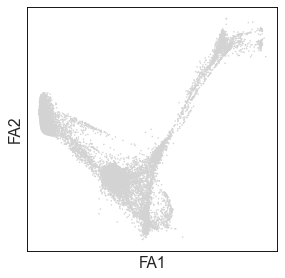

In [211]:
sc.pl.draw_graph(adata_HT)

In [214]:
stratify(adata_HT, 'sample', 'Krt17_status', normalize=False)

AT2_1mo
Krt17-    4429
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_3moMRD
Krt17-    3569
Krt17+     166
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_doxMRD
Krt17-    1769
Krt17+     180
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_pool
Krt17-    5350
Krt17+      44
Name: Krt17_status, dtype: int64

 ######################### 

transformed_SCLC
Krt17-    313
Krt17+      8
Name: Krt17_status, dtype: int64

 ######################### 



In [213]:
adata_HT[adata_HT.obs['sample'] == 'ERPMT_pool'].obs['Krt17_status'].value_counts()['Krt17+']

44

In [215]:
# written with google AI example code
# Prompt: "two proportion z test python"
from statsmodels.stats.proportion import proportions_ztest

# Data for two groups
group1_pos = adata_HT[adata_HT.obs['sample'] == 'ERPMT_pool'].obs['Krt17_status'].value_counts()['Krt17+']  # Number of successes in group 1
group1_n = adata_HT[adata_HT.obs['sample'] == 'ERPMT_pool'].obs.shape[0]      # Total observations in group 1

group2_pos = adata_HT[adata_HT.obs['sample'] == 'ERPMT_doxMRD'].obs['Krt17_status'].value_counts()['Krt17+']  # Number of successes in group 2
group2_n = adata_HT[adata_HT.obs['sample'] == 'ERPMT_doxMRD'].obs.shape[0]      # Total observations in group 2

# Create arrays for counts and observations
count = np.array([group1_pos, group2_pos])
nobs = np.array([group1_n, group2_n])

# Perform the two-proportion Z-test
z_statistic, p_value = proportions_ztest(count, nobs, alternative='two-sided')

# Print the results
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the proportions.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the proportions.")

Z-statistic: -18.5253
P-value: 0.0000
Reject the null hypothesis: There is a significant difference between the proportions.


Figure saved : /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225///HT_Krt17_status_by_sample_Barplot.svg
Figure saved : /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225///HT_Krt17_status_by_sample_Barplot_scaled.svg


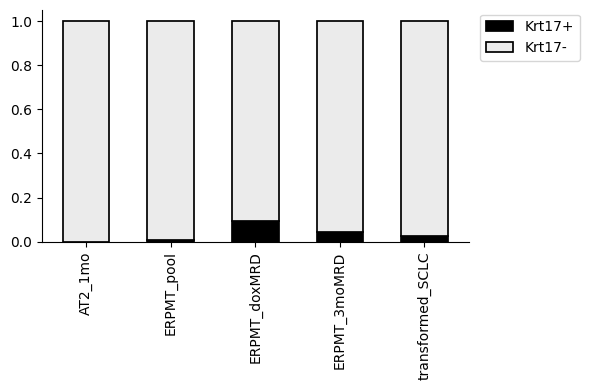

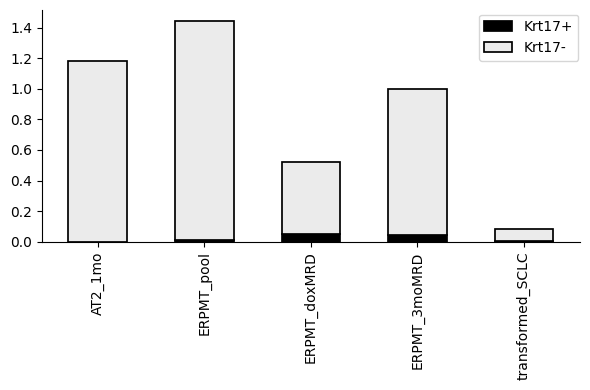

In [15]:
cMap = {'Krt17-': '#ebebeb',
        'Krt17+': '#000000'}

cellType_frac_barplot(adata_HT, group_var='sample', 
                      group_order=['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC'],
                      cellType_var='Krt17_status', cmap=cMap, prefix='HT_', figsize=(6,4))
cellType_frac_barplot(adata_HT, group_var='sample',
                      group_order=['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC'],
                      cellType_var='Krt17_status', cmap=cMap, scaled=True, prefix='HT_', figsize=(6,4))

In [127]:
stratify(adata_HT, 'sample', 'Krt17_status', normalize=True)

AT2_1mo
Krt17-    1.0
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_3moMRD
Krt17-    0.955556
Krt17+    0.044444
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_doxMRD
Krt17-    0.907645
Krt17+    0.092355
Name: Krt17_status, dtype: float64

 ######################### 

ERPMT_pool
Krt17-    0.991843
Krt17+    0.008157
Name: Krt17_status, dtype: float64

 ######################### 

transformed_SCLC
Krt17-    0.975078
Krt17+    0.024922
Name: Krt17_status, dtype: float64

 ######################### 



Figure saved : /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225///HT_Krt5_status_by_sample_Barplot.svg
Figure saved : /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225///HT_Krt5_status_by_sample_Barplot_scaled.svg


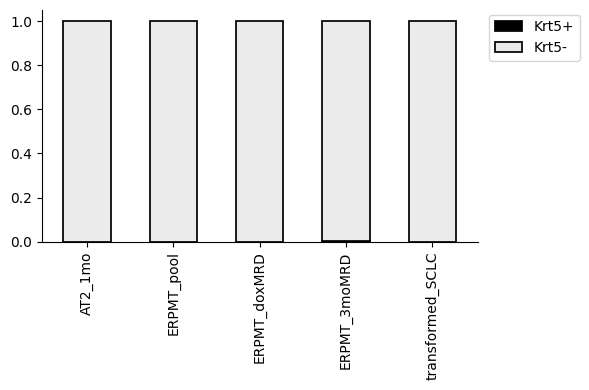

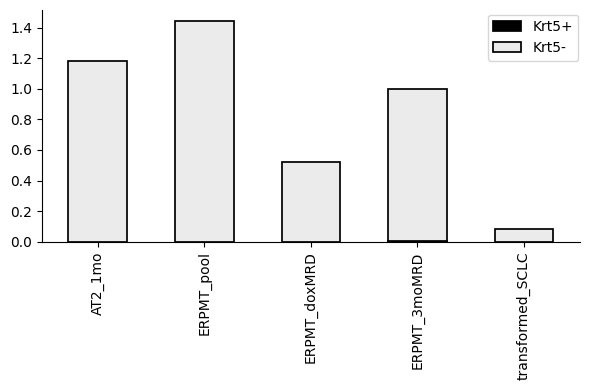

In [19]:
adata_HT.obs['Krt5_status'] = ['Krt5+' if x>0 else 'Krt5-' for x in np.ravel(adata_HT[:,'Krt5'].layers['logX'])]

cMap = {'Krt5-': '#ebebeb',
        'Krt5+': '#000000'}

cellType_frac_barplot(adata_HT, group_var='sample', 
                      group_order=['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC'],
                      cellType_var='Krt5_status', cmap=cMap, prefix='HT_', figsize=(6,4))
cellType_frac_barplot(adata_HT, group_var='sample',
                      group_order=['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC'],
                      cellType_var='Krt5_status', cmap=cMap, scaled=True, prefix='HT_', figsize=(6,4))

In [20]:
adata_HT[adata_HT.obs['Krt17_status'] == 'Krt17+'].obs['Krt5_status'].value_counts()

Krt5-    392
Krt5+      6
Name: Krt5_status, dtype: int64

### Trends

### GSEA

In [21]:
lin_prob_df = pd.read_csv('/workdir/varmus_single_cell/code/github_notebooks/Lineage_Probs_Archetype_Assignments.csv', index_col=0)

In [22]:
lin_prob_df

,Nearest_Archetype_n6
CCAAGCGAGGTCTACT-1-20-0,ARC5
AGAACCTAGCCGATTT-1-7-0,ARC5
CCCTCTCCAACTGATC-1-9-0,ARC5
AGCCAATGTCCTATAG-1-2-1,ARC6
TATTTCGTCCATACAG-1-17-0,ARC5
...,...
CTACATTGTCGAGCAA-1-9-0,ARC1
CGACAGCCAATCTCGA-1-0-1,ARC5
TTCCTTCAGCTACAAA-1-7-0,ARC6
CAACCTCAGCATCAGG-1-2-1,ARC6


In [23]:
lin_prob_df.index

Index(['CCAAGCGAGGTCTACT-1-20-0', 'AGAACCTAGCCGATTT-1-7-0',
       'CCCTCTCCAACTGATC-1-9-0', 'AGCCAATGTCCTATAG-1-2-1',
       'TATTTCGTCCATACAG-1-17-0', 'TCATTTGTCCTTCTAA-1-13-0',
       'CACACAAAGCCATGCC-1-14-0', 'TCATTCAAGTAAACTG-1-11-0',
       'TACTTCAAGGATTTGA-1-20-0', 'TTTACGTAGAGTGTGC-1-0-1',
       ...
       'ATCTCTACATGGAGAC-1-13-0', 'CTGGCAGAGAATTTGG-1-17-0',
       'GTCACGGGTACGATTC-1-1-1', 'GTAGGAGTCTGGGTCG-1-8-0',
       'TATATCCGTACAACGG-1-1-1', 'CTACATTGTCGAGCAA-1-9-0',
       'CGACAGCCAATCTCGA-1-0-1', 'TTCCTTCAGCTACAAA-1-7-0',
       'CAACCTCAGCATCAGG-1-2-1', 'GACTGATAGTCCCTAA-1-19-0'],
      dtype='object', length=80858)

In [25]:
adata_HT.obs['Nearest_Archetype_n6'] = lin_prob_df.loc[adata_HT.obs.index.map(lambda x: x+'-0').tolist(),:]['Nearest_Archetype_n6'].tolist()

In [26]:
adata_HT

AnnData object with n_obs × n_vars = 15828 × 24215
    obs: 'mt_frac', 'totReads', 'doublet_score', 'library_size', 'sample', 'origin', 'log_library_size', 'pheno_40', 'Basal cells_probs', 'Multiciliated cells_probs', 'Secretory cells_probs', 'Transitional Club-AT2_probs', 'PNEC_probs', 'Submucosal cells_probs', 'AT1_probs', 'AT2_probs', 'condition', 'ERPMT_pool_macrostate_probs', 'ERPMT_doxMRD_macrostate_probs', 'transformed_SCLC_macrostate_probs', 'AT2_1mo_macrostate_probs', 'top_macrostate', 'initial_states_probs', 'terminal_states_probs', 'project_batch', 'palantir_pseudotime', 'palantir_diff_score', 'Krt17_status', 'Krt5_status', 'Nearest_Archetype_n6'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'draw_graph', 'hvg', 'neighbors_40', 'origin_colors', 'pca', 'sample_colors', 'umap'
    obsm: 'DC', 'T_fwd_draw_graph_fa', 'X_draw_graph_fa', 'X_draw_graph_fa_extended', 'X_pca', 'X_umap', 'to_terminal_states'
    varm: 

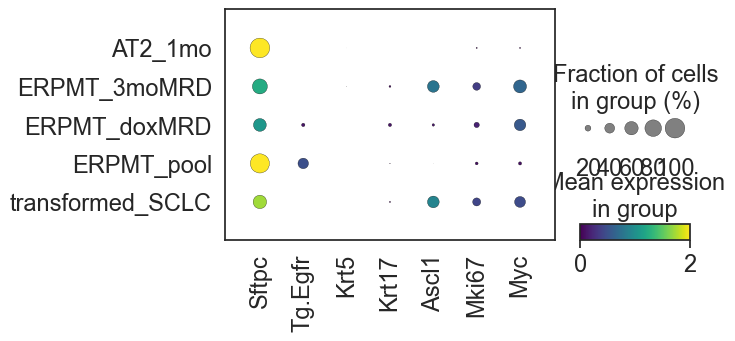

In [43]:
sns.set(style='white', font_scale=1.7)

#genes = ['Mki67', 'Top2a', 'Birc5', 'Mcm5', 'Mcm6', 'Krt5', 'Krt17', 'Krt14', 'Trp63', 'Dlk2', 'Bcam', 'Ifitm3', 'Tob1', 'Ctnnb1',
#         'Krt13', 'Krt4', 'Krt6a', 'Serpinb3a', 'Krt19', 'Krt8', 'Scgb1a1', 'Scgb3a1', 'Bpifb1', 'Tspan8', 'Muc5ac', 'Ltf', 'Lyz1', 'Lyz2',
#         'Pip', 'Ceacam5', 'Muc5b', 'Cdc20b', 'Deup1', 'Foxj1', 'Rsph1', 'Pifo', 'Dnah3', 'Foxi1', 'Bsnd', 'Igf1', 'Calca', 'Celf3', 'Slc6a17']

genes = ['Mki67', 'Sftpc', 'Krt5', 'Krt17', 'Tg.Egfr', 'Myc', 'Ascl1']

genes = [x for x in genes if x in adata_HT.var.index.tolist()]

adata_HT.X = adata_HT.layers['logX']

dotplot_df = pd.DataFrame(adata_HT[:,genes].layers['logX'], index=adata_HT[:, genes].obs['sample'], columns=genes)
dotplot_df = dotplot_df.groupby(level=0).mean()

linkage = hc.linkage(dotplot_df.T, method='complete', metric='euclidean')
col_linkage = deepcopy(linkage)
c1 = hc.leaves_list(col_linkage)

genes = dotplot_df.iloc[:,c1].columns.tolist()

sc.pl.dotplot(adata_HT,
              var_names=genes,
              groupby='sample',
              #dendrogram='dendrogram_Nearest_Archetype', 
              cmap='viridis',
              vmin=0,
              vmax=2,
              figsize=(6,3),
              save='_select_genes_sample_dotplot.svg')

sns.set(style='white', font_scale=1)

In [40]:
adata_HT.obs['sample'].value_counts()

ERPMT_pool          5394
AT2_1mo             4429
ERPMT_3moMRD        3735
ERPMT_doxMRD        1949
transformed_SCLC     321
Name: sample, dtype: int64

In [72]:
adata_sub = adata_HT[np.array(adata_HT.obs['sample'].map(lambda x: x in ['ERPMT_pool', 'ERPMT_doxMRD'])).astype(bool)].copy()

In [73]:
############### DEFINE MAST INPUT ###############

comp_list = ['Krt17_status']

input_file = '/workdir/varmus_single_cell/data/adata_HT_krt17_MRD_sub_status_comp.h5ad'

manual_var_list = ['Krt17+']

for variable in comp_list:
    
    if len(adata_sub.obs[variable].unique()) > 2:
        for var in adata_sub.obs[variable].unique():
            var = var.replace(' ','_').replace('/','_')
            adata_sub.obs[f'{var}_MAST_INPUT'] = [x.replace(' ','_').replace('/','_') 
                                              if x.replace(' ','_').replace('/','_')==var 
                                              else 'other' for x in adata_sub.obs[variable]]
    else:
        if 'other' in adata_sub.obs[variable].unique()[0]:
            var = adata_sub.obs[variable].unique()[1]
        else:
            var = manual_var_list[0]
            
        var = var.replace(' ','_').replace('/','_')
        adata_sub.obs[f'{var}_MAST_INPUT'] = [x.replace(' ','_').replace('/','_') 
                                                   if x.replace(' ','_').replace('/','_')==var 
                                                   else 'other' for x in adata_sub.obs[variable]]
        
adata_sub.write(input_file)

In [74]:
variable_sample_covar_map = {'Krt17_status': "TRUE"}

In [75]:
output_dir

'/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/'

In [76]:
adata_HT

AnnData object with n_obs × n_vars = 15828 × 24215
    obs: 'mt_frac', 'totReads', 'doublet_score', 'library_size', 'sample', 'origin', 'log_library_size', 'pheno_40', 'Basal cells_probs', 'Multiciliated cells_probs', 'Secretory cells_probs', 'Transitional Club-AT2_probs', 'PNEC_probs', 'Submucosal cells_probs', 'AT1_probs', 'AT2_probs', 'condition', 'ERPMT_pool_macrostate_probs', 'ERPMT_doxMRD_macrostate_probs', 'transformed_SCLC_macrostate_probs', 'AT2_1mo_macrostate_probs', 'top_macrostate', 'initial_states_probs', 'terminal_states_probs', 'project_batch', 'palantir_pseudotime', 'palantir_diff_score', 'Krt17_status', 'Krt5_status', 'Nearest_Archetype_n6'
    var: 'gene_ids', 'n_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'draw_graph', 'hvg', 'neighbors_40', 'origin_colors', 'pca', 'sample_colors', 'umap', 'dendrogram_Nearest_Archetype'
    obsm: 'DC', 'T_fwd_draw_graph_fa', 'X_draw_graph_fa', 'X_draw_graph_fa_extended', 'X_pca', 'X_umap',


 Running MAST with ALL GENES and sample covar==TRUE for Krt17+ 
 
 ############################### 

/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/MAST_Results_LUAD_MRD_sub/Krt17_status/Krt17+//Krt17+_vs_other__all_others_ALL_GENEs.csv not found, setting force to True
calling bash -c 'R --vanilla --args --infile "/workdir/varmus_single_cell/data/adata_HT_krt17_MRD_sub_status_comp.h5ad" --data_field "logX" --outdir "/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/MAST_Results_LUAD_MRD_sub/Krt17_status/Krt17+/" --hvg_filter "FALSE"                  --sample_covariate "TRUE" --covar_field sample --cell_filter "FALSE" --groups Krt17+_MAST_INPUT --comp-groups "Krt17+" "other" --numcores 20 --outname-str "_all_others_ALL_GENEs" < /root/scripts/MAST_new.R' > /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/MAST_Results_LUAD_MRD_sub/Krt17_status/Krt17+//stdout_all_others_ALL_GENEs.txt 2>&1

Output from stdout file /workdir/varmus_single_cell/merged_p

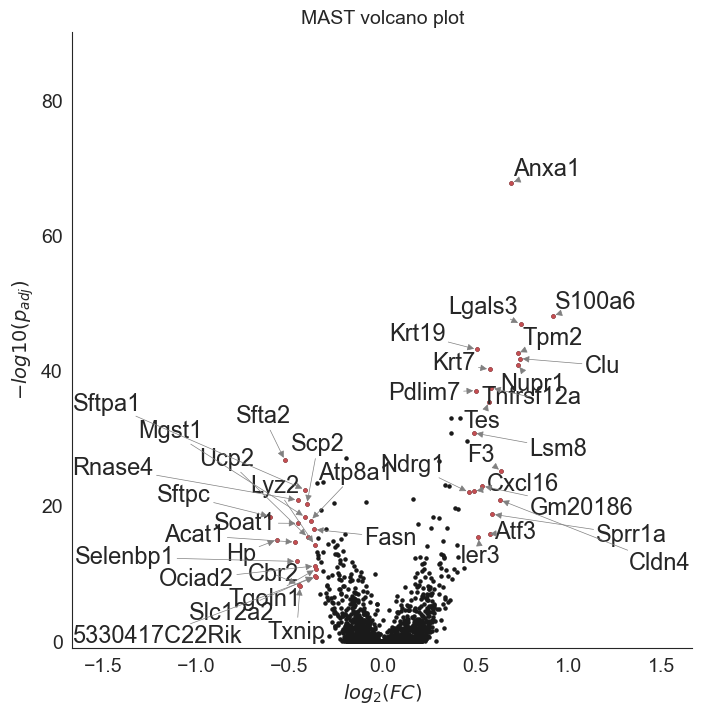

Running GSEA with ALL_GENEs and for Krt17_status 
 
 ############################### 

Dropping 71 results with no human gene mapping
calling bash -c 'parallel -j 20 < /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/GSEA_Results_ALL_GENEs_LUAD_MRD_sub/Krt17_status//commands.txt' > /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/GSEA_Results_ALL_GENEs_LUAD_MRD_sub/Krt17_status//GSEA_parallel_log.txt 2>&1

Output from stdout file /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/GSEA_Results_ALL_GENEs_LUAD_MRD_sub/Krt17_status//GSEA_parallel_log.txt is suppressed
Krt17+
(210, 11)
(210, 13)
Krt17+ 50


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Krt17+ 34


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Krt17+ 28


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Krt17+ 16


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [77]:
################### RUN MAST  ###################
    
for variable in comp_list:
    
    input_h5ad = input_file
    
    mast_outdir = output_dir + f'MAST_Results_LUAD_MRD_sub/{variable}/'
    !mkdir -p {mast_outdir}
    
    # Compare each var to rest otherwise use specified variable as positive case:
    if len(adata_sub.obs[variable].unique()) > 2:
        
        var_list = adata_sub.obs[variable].unique()
    
    # Only two conditions:
    else:
        var_list = manual_var_list
            
    for var in var_list:
        
        #print(f'Running MAST with HVGs and sample covar=={variable_sample_covar_map[variable]} for {var}', '\n')
        #
        ## Run only using HVGs:
        #my_run_mast(var, 'other', 
        #            hvg_filter='TRUE',
        #            groupName=var+'_MAST_INPUT', 
        #            sample_covariate=variable_sample_covar_map[variable],
        #            infile=input_h5ad,
        #            num_cores=30,
        #            mast_outdir=mast_outdir+var+'/',
        #            outname_str='_all_others_HVGs_ONLY',
        #            wait=True)
        
        print('\n', f'Running MAST with ALL GENES and sample covar=={variable_sample_covar_map[variable]} for {var}', '\n', '\n',
          '###############################', '\n')
        
        ## Run only using HVGs:
        my_run_mast(var, 'other', 
                    hvg_filter='FALSE',
                    groupName=var+'_MAST_INPUT', 
                    sample_covariate=variable_sample_covar_map[variable],
                    infile=input_h5ad,
                    num_cores=20,
                    mast_outdir=mast_outdir+var+'/',
                    outname_str='_all_others_ALL_GENEs',
                    wait=True)

        
    ################### READ in MAST RESULTS ###################
    
    mast_results_df = pd.DataFrame()
    
    for x in os.listdir(mast_outdir):
        for y in os.listdir(mast_outdir+x):
            if y.endswith(".csv"):
                tmp_df = read_mast_results(mast_outdir+x+'/'+y)
                tmp_df['MAST_Info'] = y[:-4]
                mast_results_df = pd.concat([mast_results_df, tmp_df])
                
    #Filter out Rpl, Rps, mt-, and Hsp genes
    mast_genes_filter = np.array((mast_results_df.index.map(lambda x: x[:3] not in 
                                                    ['Rpl', 'Rps', 'mt-']))).astype(bool)
    mast_results_df = mast_results_df[mast_genes_filter]
    #mast_results_df.head()
                
    ### Volcano Plots:    
    
    !mkdir -p {mast_outdir+'/Volcano_Plots/'}

    for x in mast_results_df['MAST_Info'].unique():
        
        label_list = mast_results_df[mast_results_df['MAST_Info'] == x].sort_values(by='log2FC', ascending=False)['log2FC'][:20].index.tolist() +\
                     mast_results_df[mast_results_df['MAST_Info'] == x].sort_values(by='log2FC', ascending=True)['log2FC'][:20].index.tolist()
        
        make_volcano_plot(mast_results_df[mast_results_df['MAST_Info'] == x], 
                          #mlog10_thresh=50, 
                          #log2FC_thresh = 0.5, 
                          #num_label=50,
                          label_list = label_list,
                          figsize=(8,8),
                          plot_outfile=mast_outdir+'/Volcano_Plots/' +x+ '.png')
        
        
    ##################### RUN GSEA #####################
    
    # Subset mast results df:
    mast_results_df_FULL = mast_results_df
    
    for gene_status in ['ALL_GENEs']:
        
        print(f'Running GSEA with {gene_status} and for {variable}', '\n', '\n',
               '###############################', '\n')
    
        # Only Care about results using all genes:
        mast_results_df = mast_results_df_FULL[mast_results_df_FULL.MAST_Info.map(lambda x: gene_status in x)]
        
        # define gsea pathways:
        gsea_dict = dict(zip(var_list,
                             ['lung_tumor_extended' for x in range(len([x.replace(' ','_').replace('/','_') 
                                                                        for x in var_list]))]))
        
        commands=[]
        outdir = output_dir + f'GSEA_Results_{gene_status}_LUAD_MRD_sub/{variable}/'
        !mkdir -p {outdir}
        
        for var in gsea_dict:
            
            var = var.replace(' ','_').replace('/','_')
            
            ## point this to the GSEA files
            gmtfile = f'/workdir/varmus_single_cell/GSEA/{gsea_dict[var]}.gmt'
            if not path.exists(gmtfile):
                print(f'{gsea_file} not found')
                break
            ct0=var.replace(' ','_').replace('/','_')
            output_root=f'{outdir}/{ct0}'
            compName=f'{ct0}'
            if path.exists(f'{output_root}/{compName}.csv'):  # already run
                continue
                
            ## edit this with the statistic you want to test
            if var not in ['SCLC_vs_PNEC_MAST_INPUT', 'SCLC_vs_PNEC_cMYC_MAST_INPUT', 'PNEC_vs_PNEC_cMYC_MAST_INPUT']:
                scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_vs_')[0] == var).astype(bool)][['scaled_rank_score']]
            else:
                scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_HVG')[0]+'_MAST_INPUT' 
                                                                       == var).astype(bool)][['scaled_rank_score']]
            
            # in my case score=0 often means no data/meaningless, remove these
            scores = scores.loc[scores.values != 0]
            scores = scores.loc[~np.isnan(scores.values)]
            if (scores.shape[0] < 2):
                continue
            scores.sort_values(by='scaled_rank_score', ascending=False, inplace=True)
            rank = gsea_linear_scale(scores)
            cmd = run_gsea(rank, output_root, gmtfile=gmtfile,
                           force=False, wait=True, label=compName, return_command_only=True,
                           gene_map=mToH_mapping)
            if cmd is None:
                print("ERROR ", compName)
            else:
                commands.append(cmd)
        gsea_command_file = f'{outdir}/commands.txt'
        with open(gsea_command_file, 'w') as filehandle:
            for command in commands:
                filehandle.write('%s\n' % command)
        run_in_background(f'parallel -j 20 < {gsea_command_file}', f'{outdir}/GSEA_parallel_log.txt', force=True, wait=True, quiet=True)
        
        
        ################ READ IN GSEA RESULTS ################
        gsea_results = pd.DataFrame()
        for var in gsea_dict.keys():
            
            var = var.replace(' ','_').replace('/','_')
            
            print(var)
            
            ## read in gmt file because we want to append category names with info in the second column
            gmtfile = f'/workdir/varmus_single_cell/GSEA/{gsea_dict[var]}.gmt'
            gmtMeta = pd.read_csv(gmtfile, index_col=None, usecols=[0,1], header=None, delimiter='\t')
            gmtMeta.columns = ['name','desc']
            
            ## gsea converts everything to upper case so we need to also
            gmtMeta['name'] = gmtMeta['name'].str.strip().str.upper()
            
            # we don't want to keep descriptions that start with '>', they are long and redundant
            gmtMeta.loc[gmtMeta['desc'].str.match('^>'),1]=''
            ct0=var.replace(' ','_').replace('/','_')
            
            ## this code is same as previous block
            compName=f'{ct0}'
            output_root=f'{outdir}/{ct0}'
            
            ## edit this with the statistic you want to test
            if var not in ['SCLC_vs_PNEC_MAST_INPUT', 'SCLC_vs_PNEC_cMYC_MAST_INPUT', 'PNEC_vs_PNEC_cMYC_MAST_INPUT']:
                scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_vs_')[0] == var).astype(bool)][['scaled_rank_score']]
            else:
                scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_HVG')[0]+'_MAST_INPUT' 
                                                                       == var).astype(bool)][['scaled_rank_score']]
            
            # in my case score=0 often means no data/meaningless, remove these
            scores = scores.loc[scores.values != 0]
            scores = scores.loc[~np.isnan(scores.values)]
            
            if (scores.shape[0] < 2):
                continue
            # with readonly=True we do not run, just read in results
            currResults = run_gsea(None, output_root, force=False, wait=True, label=compName, readonly=True)
            currResults[variable] = var
            
            print(currResults.shape)
            currResults = currResults.merge(gmtMeta, on='name')
            print(currResults.shape)
            ## add description to the pathway name
            currResults['name'] = currResults['name']
            gsea_results = pd.concat([gsea_results, currResults])
        gsea_results['new_index'] = range(gsea_results.shape[0])
        gsea_results.set_index('new_index', drop=True, inplace=True)
        
        gsea_results['name'] = gsea_results['name'].map(lambda x: x.split('>')[0])
        
        ################ GO ENRICHMENT PLOTS ################
        
        gsea_results.nes = gsea_results.nes.replace('---', 0).astype(float)
        
        plt.ioff() # Prevent plots from automatically displaying in notebook
        
        fdrf_cutoff_list = [0.25, 0.1, 0.05, 0.01]
        
        outdir = output_dir + f'GSEA_Results_{gene_status}_LUAD_MRD_sub/'
        
        !mkdir -p {outdir+'/GO_Enrichment_Plots/'}
        
        for fdrf_cutoff in fdrf_cutoff_list:
        
            pathways_to_remove = []
            
            gsea_results_sub = gsea_results[gsea_results.name.map(lambda x: x not in pathways_to_remove)]
                
            fdrf = gsea_results_sub['fdr_q'] < fdrf_cutoff
            
            for var in sorted(adata_HT.obs[variable].unique()):
                f = (gsea_results_sub[variable] == var) & (fdrf)
                
                if sum(f) == 0:
                    continue
                    
                print(var, sum(f))
                
                tmp = gsea_results_sub.loc[f]
                tmp.sort_values('nes', inplace=True, ascending=False)
                tmp = tmp.reset_index()
                
                fdrmin = np.min(np.array([x for x in gsea_results_sub.fdr_q if x!=0]))
                tmp.loc[tmp.fdr_q==0,'fdr_q'] = fdrmin
                
                tmp.fdr_q = tmp.fdr_q.apply(lambda x: -np.log10(x))
            
                sns.set_style('white')
                
                tmp['fdr_q_dir'] = [tmp.fdr_q.values[x]*np.sign(tmp.nes.values[x]) for x in range(len(tmp))]
                
                if len(tmp) > 50:
                    fig, ax = plt.subplots(figsize=(14,10))
                    #ax.tick_params(axis='both', which='both', labelsize=3)
                    plt.yticks(fontsize=4)
                else:
                    fig, ax = plt.subplots(figsize=(14,6))
                    #ax.tick_params(axis='both', which='both', labelsize=6)
                    plt.yticks(fontsize=6)
                
                #plot = plt.scatter(x=tmp['name'], y=tmp['nes'], c=tmp['nes'], 
                #                   cmap='RdBu_r', vmin=-max(abs(tmp.nes)), vmax=max(abs(tmp.nes)))
                plot = plt.scatter(x=tmp['name'], y=tmp['nes'], c=tmp['nes'], 
                                   cmap='RdBu_r', vmin=-4, vmax=4)
                plt.clf()
                #plt.colorbar(plot)
                
                cmap = plt.cm.RdBu_r
                #norm = matplotlib.colors.Normalize(vmin=-max(abs(tmp.nes)), vmax=max(abs(tmp.nes)))
                norm = matplotlib.colors.Normalize(vmin=-2, vmax=2)
                
                colors = [matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(x) 
                          for x in tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).nes]
                
                g = sns.barplot(data=tmp, 
                                x='fdr_q_dir',
                                y='name',
                                order=tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).name)
                
                for i,thisbar in enumerate(g.patches):
                    thisbar.set_alpha(1)
                    thisbar.set_edgecolor('black')
                    thisbar.set_linewidth(0.5)
                    thisbar.set_color(colors[i])
                
                plt.ylabel('')
                
                if len(tmp) > 50:
                    plt.yticks(fontsize=4)
                else:
                    plt.yticks(fontsize=6)
                    
                #g.legend_.remove()
                
                plt.xlabel('-log10(FDR) * sign(NES)')
                
                plt.savefig(outdir+f'/GO_Enrichment_Plots/'+var+f'_Pathway_GO_Bar_Plot_Directed_FDR_{fdrf_cutoff}'+ '.png',
                            dpi=400,
                            bbox_inches='tight',
                            transparent=True)
                plt.close(fig)
            
        plt.ion()

In [204]:
for gene_status in ['ALL_GENEs']:

    print(f'Running GSEA with {gene_status} and for {variable}', '\n', '\n',
           '###############################', '\n')

    # Only Care about results using all genes:
    mast_results_df = mast_results_df_FULL[mast_results_df_FULL.MAST_Info.map(lambda x: gene_status in x)]

    # define gsea pathways:
    gsea_dict = dict(zip(var_list,
                         ['lung_tumor_extended' for x in range(len([x.replace(' ','_').replace('/','_') 
                                                                    for x in var_list]))]))

    commands=[]
    outdir = output_dir + f'GSEA_Results_{gene_status}_LUAD_MRD_sub/{variable}/'
    !mkdir -p {outdir}

    for var in gsea_dict:

        var = var.replace(' ','_').replace('/','_')

        ## point this to the GSEA files
        gmtfile = f'/workdir/varmus_single_cell/GSEA/{gsea_dict[var]}.gmt'
        if not path.exists(gmtfile):
            print(f'{gsea_file} not found')
            break
        ct0=var.replace(' ','_').replace('/','_')
        output_root=f'{outdir}/{ct0}'
        compName=f'{ct0}'
        if path.exists(f'{output_root}/{compName}.csv'):  # already run
            continue

        ## edit this with the statistic you want to test
        if var not in ['SCLC_vs_PNEC_MAST_INPUT', 'SCLC_vs_PNEC_cMYC_MAST_INPUT', 'PNEC_vs_PNEC_cMYC_MAST_INPUT']:
            scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_vs_')[0] == var).astype(bool)][['scaled_rank_score']]
        else:
            scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_HVG')[0]+'_MAST_INPUT' 
                                                                   == var).astype(bool)][['scaled_rank_score']]

        # in my case score=0 often means no data/meaningless, remove these
        scores = scores.loc[scores.values != 0]
        scores = scores.loc[~np.isnan(scores.values)]
        if (scores.shape[0] < 2):
            continue
        scores.sort_values(by='scaled_rank_score', ascending=False, inplace=True)
        rank = gsea_linear_scale(scores)
        cmd = run_gsea(rank, output_root, gmtfile=gmtfile,
                       force=False, wait=True, label=compName, return_command_only=True,
                       gene_map=mToH_mapping)
        if cmd is None:
            print("ERROR ", compName)
        else:
            commands.append(cmd)
    gsea_command_file = f'{outdir}/commands.txt'
    with open(gsea_command_file, 'w') as filehandle:
        for command in commands:
            filehandle.write('%s\n' % command)
    run_in_background(f'parallel -j 20 < {gsea_command_file}', f'{outdir}/GSEA_parallel_log.txt', force=True, wait=True, quiet=True)


    ################ READ IN GSEA RESULTS ################
    gsea_results = pd.DataFrame()
    for var in gsea_dict.keys():

        var = var.replace(' ','_').replace('/','_')

        print(var)

        ## read in gmt file because we want to append category names with info in the second column
        gmtfile = f'/workdir/varmus_single_cell/GSEA/{gsea_dict[var]}.gmt'
        gmtMeta = pd.read_csv(gmtfile, index_col=None, usecols=[0,1], header=None, delimiter='\t')
        gmtMeta.columns = ['name','desc']

        ## gsea converts everything to upper case so we need to also
        gmtMeta['name'] = gmtMeta['name'].str.strip().str.upper()

        # we don't want to keep descriptions that start with '>', they are long and redundant
        gmtMeta.loc[gmtMeta['desc'].str.match('^>'),1]=''
        ct0=var.replace(' ','_').replace('/','_')

        ## this code is same as previous block
        compName=f'{ct0}'
        output_root=f'{outdir}/{ct0}'

        ## edit this with the statistic you want to test
        if var not in ['SCLC_vs_PNEC_MAST_INPUT', 'SCLC_vs_PNEC_cMYC_MAST_INPUT', 'PNEC_vs_PNEC_cMYC_MAST_INPUT']:
            scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_vs_')[0] == var).astype(bool)][['scaled_rank_score']]
        else:
            scores = mast_results_df[mast_results_df.MAST_Info.map(lambda x: x.split('_HVG')[0]+'_MAST_INPUT' 
                                                                   == var).astype(bool)][['scaled_rank_score']]

        # in my case score=0 often means no data/meaningless, remove these
        scores = scores.loc[scores.values != 0]
        scores = scores.loc[~np.isnan(scores.values)]

        if (scores.shape[0] < 2):
            continue
        # with readonly=True we do not run, just read in results
        currResults = run_gsea(None, output_root, force=False, wait=True, label=compName, readonly=True)
        currResults[variable] = var

        print(currResults.shape)
        currResults = currResults.merge(gmtMeta, on='name')
        print(currResults.shape)
        ## add description to the pathway name
        currResults['name'] = currResults['name']
        gsea_results = pd.concat([gsea_results, currResults])
    gsea_results['new_index'] = range(gsea_results.shape[0])
    gsea_results.set_index('new_index', drop=True, inplace=True)

    gsea_results['name'] = gsea_results['name'].map(lambda x: x.split('>')[0])

    ################ GO ENRICHMENT PLOTS ################

    sns.set(font_scale=1.5)
    
    gsea_results.nes = gsea_results.nes.replace('---', 0).astype(float)

    plt.ioff() # Prevent plots from automatically displaying in notebook

    fdrf_cutoff_list = [0.25, 0.1, 0.05, 0.01]

    outdir = output_dir + f'GSEA_Results_{gene_status}_LUAD_MRD_sub/'

    !mkdir -p {outdir+'/GO_Enrichment_Plots/'}

    for fdrf_cutoff in fdrf_cutoff_list:

        pathways_to_remove = []

        gsea_results_sub = gsea_results[gsea_results.name.map(lambda x: x not in pathways_to_remove)]

        fdrf = gsea_results_sub['fdr_q'] < fdrf_cutoff

        for var in sorted(adata_HT.obs[variable].unique()):
            f = (gsea_results_sub[variable] == var) & (fdrf)

            if sum(f) == 0:
                continue

            print(var, sum(f))

            tmp = gsea_results_sub.loc[f]
            tmp.sort_values('nes', inplace=True, ascending=False)
            tmp = tmp.reset_index()

            fdrmin = np.min(np.array([x for x in gsea_results_sub.fdr_q if x!=0]))
            tmp.loc[tmp.fdr_q==0,'fdr_q'] = fdrmin

            tmp.fdr_q = tmp.fdr_q.apply(lambda x: -np.log10(x))

            sns.set_style('white')

            tmp['fdr_q_dir'] = [tmp.fdr_q.values[x]*np.sign(tmp.nes.values[x]) for x in range(len(tmp))]

            tmp.name = tmp.name.map(lambda x: x.replace('_', ' '))
            
            if len(tmp) > 50:
                fig, ax = plt.subplots(figsize=(14,10))
                #ax.tick_params(axis='both', which='both', labelsize=3)
                plt.yticks(fontsize=4)
            else:
                fig, ax = plt.subplots(figsize=(10,9))
                #ax.tick_params(axis='both', which='both', labelsize=6)
                plt.yticks(fontsize=8)

            #plot = plt.scatter(x=tmp['name'], y=tmp['nes'], c=tmp['nes'], 
            #                   cmap='RdBu_r', vmin=-max(abs(tmp.nes)), vmax=max(abs(tmp.nes)))
            plot = plt.scatter(x=tmp['name'], y=tmp['nes'], c=tmp['nes'], 
                               cmap='RdBu_r', vmin=-4, vmax=4)
            plt.clf()
            plt.colorbar(plot)

            cmap = plt.cm.RdBu_r
            #norm = matplotlib.colors.Normalize(vmin=-max(abs(tmp.nes)), vmax=max(abs(tmp.nes)))
            norm = matplotlib.colors.Normalize(vmin=-4, vmax=4)

            colors = [matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(x) 
                      for x in tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).nes]

            g = sns.barplot(data=tmp, 
                            x='fdr_q_dir',
                            y='name',
                            order=tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).name)

            for i,thisbar in enumerate(g.patches):
                thisbar.set_alpha(1)
                thisbar.set_edgecolor('black')
                thisbar.set_linewidth(0.5)
                thisbar.set_color(colors[i])

            plt.ylabel('')

            if len(tmp) > 50:
                plt.yticks(fontsize=4)
            else:
                plt.yticks(fontsize=8)

            #g.legend_.remove()

            plt.xlabel('-log10(FDR) * sign(NES)')

            plt.savefig(outdir+f'/GO_Enrichment_Plots/'+var+f'_Pathway_GO_Bar_Plot_Directed_FDR_{fdrf_cutoff}'+ '.svg',
                        dpi=400,
                        bbox_inches='tight',
                        transparent=True)
            plt.close(fig)

    plt.ion()

sns.set(font_scale=1)

Running GSEA with ALL_GENEs and for Krt17_status 
 
 ############################### 

calling bash -c 'parallel -j 20 < /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/GSEA_Results_ALL_GENEs_LUAD_MRD_sub/Krt17_status//commands.txt' > /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/GSEA_Results_ALL_GENEs_LUAD_MRD_sub/Krt17_status//GSEA_parallel_log.txt 2>&1

Output from stdout file /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/GSEA_Results_ALL_GENEs_LUAD_MRD_sub/Krt17_status//GSEA_parallel_log.txt is suppressed
Krt17+
(210, 11)
(210, 13)
Krt17+ 50


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


Krt17+ 34


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


Krt17+ 28


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


Krt17+ 16


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


In [81]:
tmp = mast_results_df

tmp = tmp[np.array((np.abs(tmp.log2FC)<0.25) &
                   (tmp.bonferroni<0.01))]

In [90]:
tmp.loc['Krt18',:]

p                                                         0.0
log2FC                                               0.247142
ci.hi                                                0.345554
ci.lo                                                0.148729
fdr                                                       0.0
bonferroni                                                0.0
rank_score                                         363.397115
FC                                                   1.186853
scaled_rank_score                                   89.810557
abs_scaled_rank_score                               89.810557
MAST_Info                Krt17+_vs_other_all_others_ALL_GENEs
Name: Krt18, dtype: object

In [104]:
dotplot_df

,Krt18,Cstb,Psmd8,St3gal4,Krt8,Tpm2,Capza2,Eif4ebp1,Ceacam1,Myl12a,Tmem243,Scp2,Abca3,Fasn,Soat1,Mxd4,Car8,Fgfr2,Atp8a1,Cat
Krt17_status,,,,,,,,,,,,,,,,,,,,
Krt17+,2.232965,1.522823,1.402552,0.625902,2.176519,0.824775,1.230242,1.083657,0.515214,1.526852,0.472487,0.983684,0.307763,0.535581,0.450231,0.577959,0.525578,0.242322,0.452110,0.272000
Krt17-,1.613735,1.148649,0.997119,0.326568,1.583405,0.205918,0.860622,0.465436,0.251542,1.289639,1.027441,1.481866,1.108808,1.197827,1.048606,0.844547,1.062226,0.768369,1.105895,0.837575


/tmp/ipykernel_326147/3916682017.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dotplot_df = dotplot_df.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

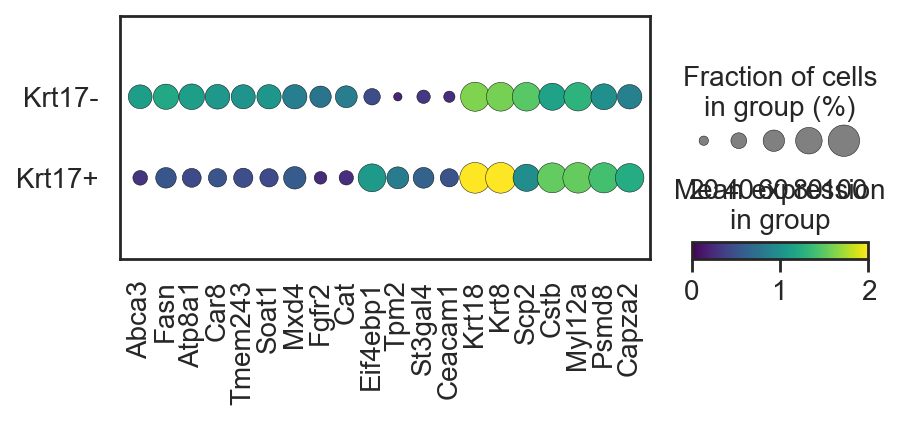

In [112]:
sc.set_figure_params(dpi=80, dpi_save=300)

sns.set(style='white', font_scale=1.25)

genes = tmp.sort_values(by='scaled_rank_score', ascending=False).index.tolist()[:10]+tmp.sort_values(by='scaled_rank_score', ascending=True).index.tolist()[:10]

adata_HT.X = adata_HT.layers['logX']

dotplot_df = pd.DataFrame(adata_HT[:,genes].layers['logX'], index=adata_HT[:, genes].obs['Krt17_status'], columns=genes)
dotplot_df = dotplot_df.groupby(level=0).mean()

dotplot_df=dotplot_df.loc[['Krt17-', 'Krt17+'],:]

linkage = hc.linkage(dotplot_df.T, method='complete', metric='euclidean')
col_linkage = deepcopy(linkage)
c1 = hc.leaves_list(col_linkage)

genes = dotplot_df.iloc[:,c1].columns.tolist()

sc.pl.dotplot(adata_HT,
              var_names=genes,
              groupby='Krt17_status',
              categories_order=['Krt17-', 'Krt17+'],
              #dendrogram='dendrogram_Nearest_Archetype', 
              cmap='viridis',
              vmin=0,
              vmax=2,
              figsize=(6,2),
              save='_top_Krt17_DEGs_Krt17_status_dotplot.png')

In [108]:
dotplot_df

,Krt18,Cstb,Psmd8,St3gal4,Krt8,Tpm2,Capza2,Eif4ebp1,Ceacam1,Myl12a,Tmem243,Scp2,Abca3,Fasn,Soat1,Mxd4,Car8,Fgfr2,Atp8a1,Cat
Krt17_status,,,,,,,,,,,,,,,,,,,,
Krt17-,1.613735,1.148649,0.997119,0.326568,1.583405,0.205918,0.860622,0.465436,0.251542,1.289639,1.027441,1.481866,1.108808,1.197827,1.048606,0.844547,1.062226,0.768369,1.105895,0.837575
Krt17+,2.232965,1.522823,1.402552,0.625902,2.176519,0.824775,1.230242,1.083657,0.515214,1.526852,0.472487,0.983684,0.307763,0.535581,0.450231,0.577959,0.525578,0.242322,0.452110,0.272000


## Analyze Full Tumor-Epithelium Dataset

### Krt17

In [14]:
adata_TEC.obs['Krt17_status'] = ['Krt17+' if x>0 else 'Krt17-' for x in np.ravel(adata_TEC[:,'Krt17'].layers['logX'])]

In [15]:
adata_TEC.obs['Krt17_status'].value_counts()

Krt17-    79463
Krt17+     1932
Name: Krt17_status, dtype: int64

In [16]:
adata_TEC.obs['Krt17_status'].value_counts(normalize=True)

Krt17-    0.976264
Krt17+    0.023736
Name: Krt17_status, dtype: float64

In [19]:
stratify(adata_TEC, 'sample', 'Krt17_status')

AT2_1mo
Krt17-    4433
Name: Krt17_status, dtype: int64

 ######################### 

AT2_1moPten
Krt17-    4318
Name: Krt17_status, dtype: int64

 ######################### 

AT2_cMYC1mo
Krt17-    4122
Krt17+       1
Name: Krt17_status, dtype: int64

 ######################### 

EPMT
Krt17-    4231
Krt17+      50
Name: Krt17_status, dtype: int64

 ######################### 

EPMT_MRD
Krt17-    4232
Krt17+      12
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_1
Krt17-    1056
Krt17+       2
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_2
Krt17-    1293
Krt17+       2
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_3
Krt17-    1105
Krt17+       6
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_3moMRD
Krt17-    3576
Krt17+     166
Name: Krt17_status, dtype: int64

 ######################### 

ERPMT_MRDrestart
Krt17-    4628
Krt17+     176
Name: Krt17_status, dtype: int64

 ######################### 



Figure saved : /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225///Krt17_status_by_sample_Barplot.png
Figure saved : /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225///Krt17_status_by_sample_Barplot_scaled.png


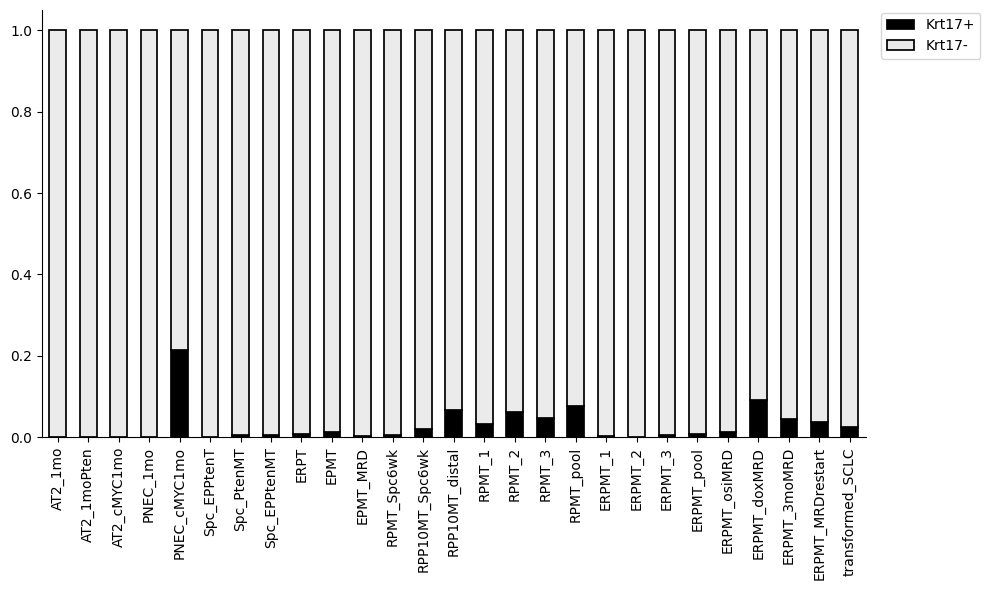

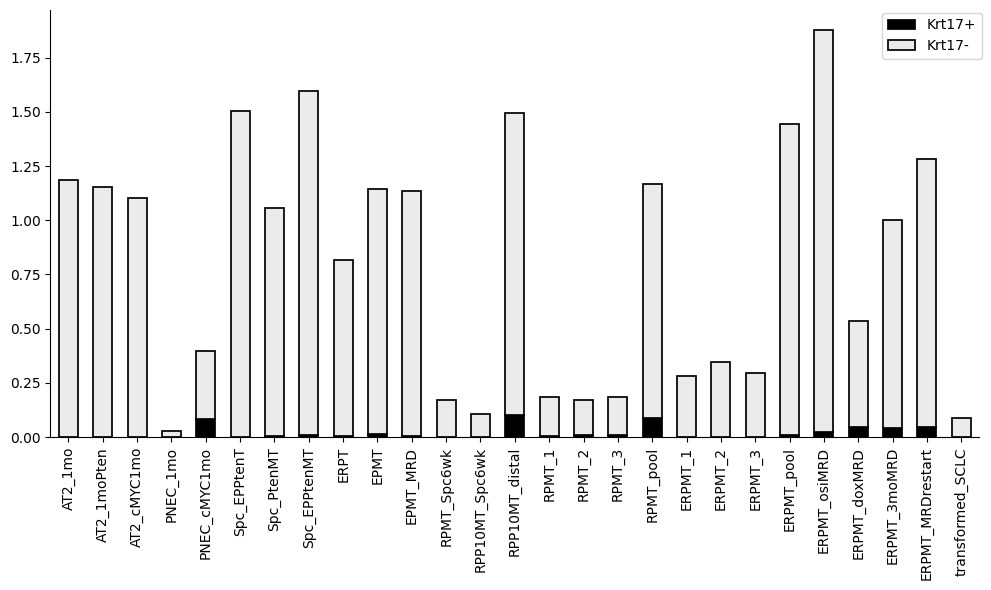

In [105]:
cMap = {'Krt17-': '#ebebeb',
        'Krt17+': '#000000'}

cellType_frac_barplot(adata_TEC, group_var='sample', 
                      group_order=['AT2_1mo', 'AT2_1moPten', 'AT2_cMYC1mo', 'PNEC_1mo', 'PNEC_cMYC1mo', 'Spc_EPPtenT', 'Spc_PtenMT', 'Spc_EPPtenMT',
                                   'ERPT', 'EPMT', 'EPMT_MRD', 'RPMT_Spc6wk', 'RPP10MT_Spc6wk', 'RPP10MT_distal', 'RPMT_1', 'RPMT_2', 'RPMT_3', 'RPMT_pool', 
                                   'ERPMT_1', 'ERPMT_2', 'ERPMT_3', 'ERPMT_pool', 'ERPMT_osiMRD', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'ERPMT_MRDrestart', 'transformed_SCLC',],
                      cellType_var='Krt17_status', cmap=cMap, figsize=(10,6))
cellType_frac_barplot(adata_TEC, group_var='sample',
                      group_order=['AT2_1mo', 'AT2_1moPten', 'AT2_cMYC1mo', 'PNEC_1mo', 'PNEC_cMYC1mo', 'Spc_EPPtenT', 'Spc_PtenMT', 'Spc_EPPtenMT',
                                   'ERPT', 'EPMT', 'EPMT_MRD', 'RPMT_Spc6wk', 'RPP10MT_Spc6wk', 'RPP10MT_distal', 'RPMT_1', 'RPMT_2', 'RPMT_3', 'RPMT_pool', 
                                   'ERPMT_1', 'ERPMT_2', 'ERPMT_3', 'ERPMT_pool', 'ERPMT_osiMRD', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'ERPMT_MRDrestart', 'transformed_SCLC',],
                      cellType_var='Krt17_status', cmap=cMap, scaled=True, figsize=(10,6))

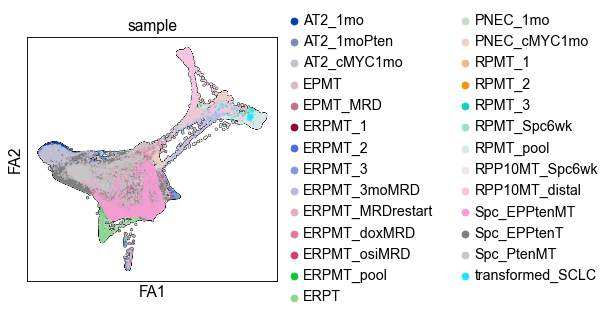

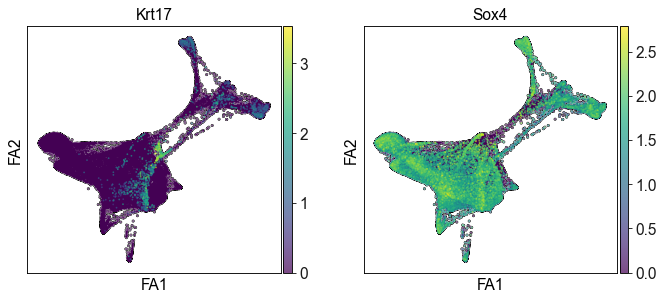

In [54]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300)

adata_TEC.X = adata_TEC.layers['logX']

sc.pl.draw_graph(adata_TEC, s=10, add_outline=True, color=f'sample')
sc.pl.draw_graph(adata_TEC, s=10, add_outline=True, cmap='viridis', color=[f'Krt17', 'Sox4'])

## All MRD subset

In [79]:
adata_TEC.obs['sample'].value_counts()

ERPMT_osiMRD        7019
Spc_EPPtenMT        5966
Spc_EPPtenT         5621
RPP10MT_distal      5596
ERPMT_pool          5397
ERPMT_MRDrestart    4804
AT2_1mo             4433
RPMT_pool           4372
AT2_1moPten         4318
EPMT                4281
EPMT_MRD            4244
AT2_cMYC1mo         4123
Spc_PtenMT          3960
ERPMT_3moMRD        3742
ERPT                3060
ERPMT_doxMRD        2001
PNEC_cMYC1mo        1487
ERPMT_2             1295
ERPMT_3             1111
ERPMT_1             1058
RPMT_1               696
RPMT_3               693
RPMT_Spc6wk          645
RPMT_2               642
RPP10MT_Spc6wk       392
transformed_SCLC     331
PNEC_1mo             108
Name: sample, dtype: int64

In [169]:
adata_sub = adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x in 
                                                           ['ERPMT_3moMRD', 'ERPMT_doxMRD', 'ERPMT_osiMRD', 'ERPMT_MRDrestart'])).astype(bool)].copy()

In [170]:
adata_sub.obs['sample'].value_counts()

ERPMT_osiMRD        7019
ERPMT_MRDrestart    4804
ERPMT_3moMRD        3742
ERPMT_doxMRD        2001
Name: sample, dtype: int64

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Found 4440 highly variable genes
/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225//hvgs_scanpy_cellranger_batch_key_sample.png


computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:09)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


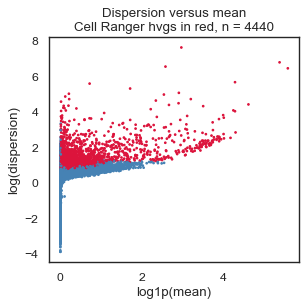

In [171]:
# Compute HVGs:
sns.set(style='white')
adata_sub.X = adata_sub.layers['X']

batch_key = 'sample'
sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', batch_key=batch_key, n_bins=20, max_mean=np.inf)
colors_cell_ranger = [boolean_to_color[True] if x >0 else boolean_to_color[False]
                      for x in adata_sub.var['highly_variable']]
plt.scatter(np.log1p(adata_sub.var['means']), np.log(adata_sub.var['dispersions']),
            s=2, c=colors_cell_ranger)
plt.xlabel('log1p(mean)')
plt.ylabel('log(dispersion)')
n=sum(adata_sub.var["highly_variable"])
plt.title(f'Dispersion versus mean\nCell Ranger hvgs in red, n = {n}')
print(f'Found {n} highly variable genes')

fn = output_dir + f'/hvgs_scanpy_cellranger_batch_key_{batch_key}.png'
plt.tight_layout()
print(fn)
plt.savefig(fn, dpi=400)

# Compute PCA:
adata_sub.X =  adata_sub.layers['logX']
sc.pp.pca(adata_sub, n_comps=100)

In [172]:
# Function to optimize the number of PCs to retain based on the linear deviation method
# A linear deviation threshold of 1e-5 is the default, as this has empirically worked well for most cases
# Returns the optimal number of PCs to keep (sensitive to starting number of PCs)
# The optimize_dev_thr function can be used to test the threshold used here.

def optimize_pcs(adata, pca_name='pca', dev_thr=1e-5, save=True, fn='PCA_linear_deviation_optimization.png'):

    plt.style.use('default')
    
    if pca_name not in adata.uns.keys():
        exit(f'ERROR: {pca_name} not in adata.')
    
    x = range(len(adata.uns[pca_name]['variance_ratio']))
    y = np.cumsum(adata.uns[pca_name]['variance_ratio'])
    
    deviation = []
    slopes = []
    
    #dev_thr = 1e-5
    thr_hit=False
    
    opt_n_pcs_linear_dev=0
    
    fig = plt.subplots(figsize=(6,6))
    
    for i in range(len(x)-2):
        
        tmp_slope = (y[i+1] - y[i]) / (x[i+1] - x[i])
        tmp_int = y[i] - tmp_slope*x[i]
        
        plt.scatter(x, y, s=10, color='blue')
        
        y_line = [tmp_slope*x + tmp_int for x in x]
        
        tmp_dev = abs(y_line[i+2] - y[i+2])
        
        deviation.append(tmp_dev)
        
        slopes.append(tmp_slope)
        
        plt.plot(x, y_line, color='grey', linewidth=0.5)
        
        if (tmp_dev < dev_thr) and (thr_hit==False):
            #print(f'Optimal nPCs = {i+1}')
            #print(f'Optimal PCs index = {i}')
            #print(f'Deviation = {tmp_dev}')
            
            opt_n_pcs_linear_dev = i
            
            plt.scatter(x[i], y[i], s=15, color='red')
            plt.axvline(x[i], color='red', linestyle='--', linewidth=1)
            
            thr_hit=True
        
        plt.xlabel('PCs Ranked')
        plt.ylabel('Cumulative Variance')
        plt.title(f'Cumulative Explained Variance, i = {opt_n_pcs_linear_dev} | nPCs = {opt_n_pcs_linear_dev+1}')
        
        plt.ylim([y[0]*0.9, y[-1]*1.1])

    if save:
        fn = f'{output_dir}/{fn}'
        plt.tight_layout()
        print(fn)
        plt.savefig(fn, dpi=400)

    return opt_n_pcs_linear_dev+1
        
# Function to test different linear deviation thresholds for optimizing nPCs

# We want to choose the deviation threshold that is the inflection point in the nPC -by- threshold plot. 
# The number of PCs is stable for a wide range of thresholds (representing another valid choice) and nPCs shoots up after becoming slightly more stringent. 
# We take the point right before the number of PCs begins to shoot up
def optimize_dev_thr(adata, pca_name, save=False):
    
    plt.style.use('default')
    if pca_name not in adata.uns.keys():
        exit(f'ERROR: {pca_name} not in adata.')
    
    x = range(len(adata.uns[pca_name]['variance_ratio']))
    y = np.cumsum(adata.uns[pca_name]['variance_ratio'])
    
    end_line_slope = (y[-1] - y[-2]) / (x[-1] - x[-2])
    end_line_int = y[-1] - end_line_slope*x[-1]
    
    deviation = []
    slopes = []
    dev_thr_list = [0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002,
                    0.0001, 0.00009, 0.00008, 0.00007, 0.00006, 0.00005, 0.00004, 0.00003, 0.00002, 
                    0.00001, 0.000009, 0.000008, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002,
                    0.00000001, 0.000000001, 0.0000000001]
    
    thr_hit=False
    
    opt_n_pcs_linear_dev_list=[]
    
    for dev_thr in dev_thr_list:
        
        print(dev_thr)
        thr_hit=False
        
        for i in range(len(x)-2):
            
            tmp_slope = (y[i+1] - y[i]) / (x[i+1] - x[i])
            tmp_int = y[i] - tmp_slope*x[i]
            
            plt.scatter(x, y, s=10, color='blue')
            
            y_line = [tmp_slope*x + tmp_int for x in x]
            
            tmp_dev = abs(y_line[i+2] - y[i+2])
            
            deviation.append(tmp_dev)
            
            slopes.append(tmp_slope)
            
            plt.plot(x, y_line, color='grey', linewidth=0.5)
            
            if (tmp_dev < dev_thr) and (thr_hit==False):
                print(f'Optimal nPCs = {i+1}')
                print(f'Optimal PCs index = {i}')
                print(f'Deviation = {tmp_dev}')
                
                opt_n_pcs_linear_dev = i
                opt_n_pcs_linear_dev_list.append(i)
                
                plt.scatter(x[i], y[i], s=15, color='red')
                plt.axvline(x[i], color='red', linestyle='--', linewidth=1)
                
                thr_hit=True
        
        if thr_hit==False:
            print(f'Optimal nPCs = {len(x)}')
            print(f'Optimal PCs index = {len(x)-1}')
            print(f'Deviation = {tmp_dev}')
            
            opt_n_pcs_linear_dev = len(x)-1
            opt_n_pcs_linear_dev_list.append(len(x)-1)
            
            plt.scatter(x[i], y[i], s=15, color='red')
            plt.axvline(x[i], color='red', linestyle='--', linewidth=1)
            
            thr_hit=True
            
        plt.xlabel('PCs Ranked')
        plt.ylabel('Cumulative Variance')
        plt.title(f'Dev Thr = {dev_thr}, i = {opt_n_pcs_linear_dev} | nPCs = {opt_n_pcs_linear_dev+1}')
        
        plt.ylim([y[0]*0.9, y[-1]*1.1])

        if save:
            fn =  + f'{output_dir}/PCA_linear_deviation_optimization_dev_thr_{dev_thr}.png'
            plt.tight_layout()
            print(fn)
            plt.savefig(fn, dpi=400)

        plt.show()
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    plt.plot(dev_thr_list, opt_n_pcs_linear_dev_list)
    plt.scatter(dev_thr_list, opt_n_pcs_linear_dev_list, color='red', s=10)
    
    ax.invert_xaxis()
    plt.ylabel('Optimal PCs')
    plt.xlabel('Deviation Threshold')

    if save:
        fn = f'{output_dir}/PCA_linear_deviation_optimization_dev_thr_stability.png'
        plt.tight_layout()
        print(fn)
        plt.savefig(fn, dpi=400)
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    plt.plot(dev_thr_list[9:], opt_n_pcs_linear_dev_list[9:])
    plt.scatter(dev_thr_list[9:], opt_n_pcs_linear_dev_list[9:], color='red', s=10)
    
    ax.invert_xaxis()
    plt.ylabel('Optimal PCs')
    plt.xlabel('Deviation Threshold')

    if save:
        fn = f'{output_dir}/PCA_linear_deviation_optimization_dev_thr_stability_2.png'
        plt.tight_layout()
        print(fn)
        plt.savefig(fn, dpi=400)

/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225//PCA_linear_deviation_optimization.png
Linear Deviation Optimal PCs = 44


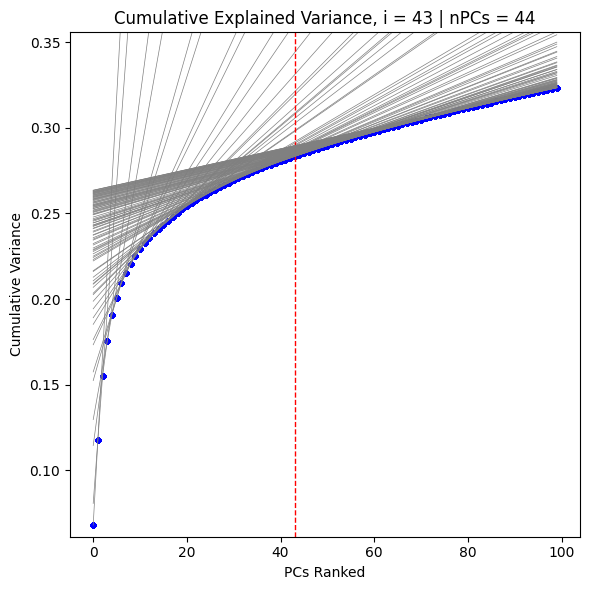

In [173]:
# Optimize for pRes

n = optimize_pcs(adata_sub, pca_name='pca', dev_thr=4e-6)
print(f'Linear Deviation Optimal PCs = {n}')

In [174]:
adata_sub.obsm[f'X_pca'] = adata_sub.obsm[f'X_pca'][:,:n]

In [175]:
adata_sub.obsm['X_pca'].shape

(17566, 44)

In [176]:
sc.pp.neighbors(adata_sub, n_neighbors=30)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 44
    computed neighbors (0:00:06)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


In [177]:
sc.tl.umap(adata_sub)

computing UMAP


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


In [178]:
sample_cmap = {'AT2_1mo': '#AD0404', 
               'ERPMT_pool': '#ff0000', 
               'ERPMT_doxMRD': '#E896D1', 
               'ERPMT_3moMRD': '#9012F1', 
               'transformed_SCLC': '#46A8FF', 
               'RPMT_pool': '#0432ff',
               'ERPMT_MRDrestart': '#d2b14c',
               'ERPMT_doxMRD': '#eca9e5',
               'ERPMT_osiMRD': '#a2df8d'}

adata_sub.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_sub.obs['sample'].unique())]

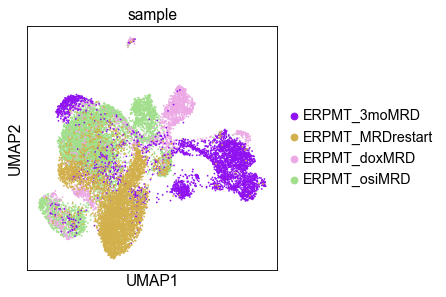

In [179]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300)

sc.pl.umap(adata_sub, color='sample', add_outline=False, s=10, save='_MRDs_sample.svg')

In [180]:
# Define functions for vmin and vmax of genes expression:

def get_vmin(values):
    p=0.05
    vmin=float(np.quantile(values, p))
    if vmin<=0:
        vmin=0
    return float(vmin)

def get_vmax(values):
    p=0.95
    vmax=float(np.quantile(values, p))
    if vmax<=0:
        vmax=0.1
    return float(vmax)

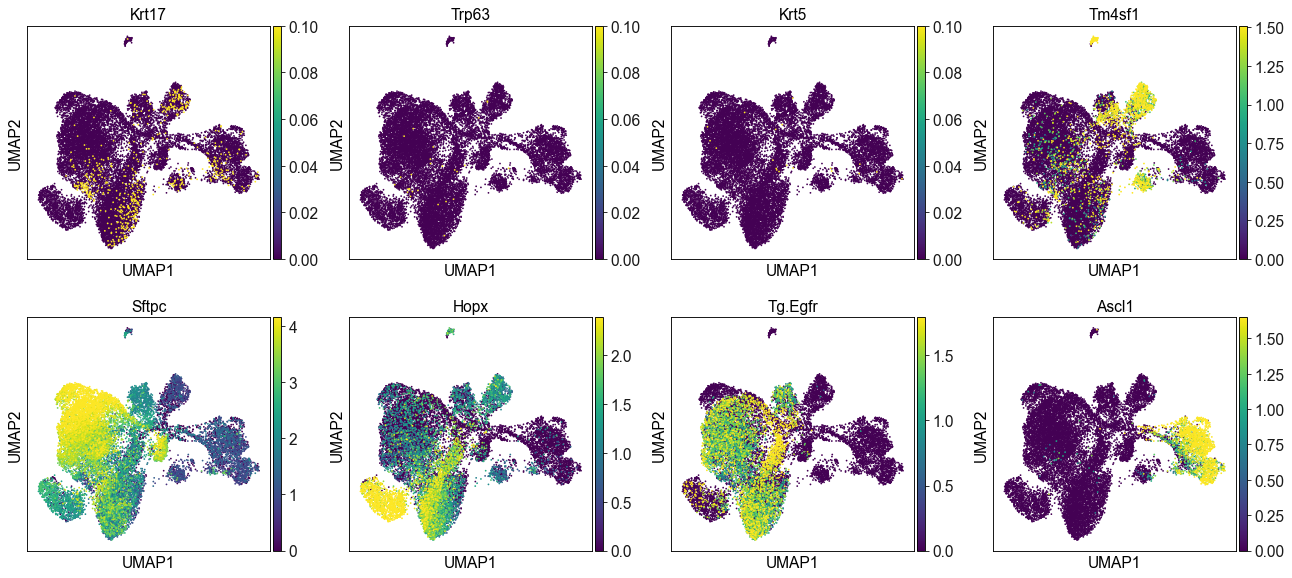

In [181]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300)

adata_sub.X = adata_sub.layers['logX']

genes = ['Krt17', 'Trp63', 'Krt5', 'Tm4sf1', 'Sftpc', 'Hopx', 'Tg.Egfr', 'Ascl1',]

#sc.pl.umap(adata_sub, color=genes, add_outline=False, vmin=0, vmax=get_vmax, cmap='viridis', ncols=4, s=10, save='_MRDs_select_genes.png')
sc.pl.umap(adata_sub, color=genes, add_outline=False, vmin=0, vmax=get_vmax, cmap='viridis', ncols=4, s=10, save='_MRDs_select_genes.svg')

In [182]:
mpas_genes = ['PHLDA1', 'SPRY2', 'SPRY4', 'DUSP4', 'DUSP6', 'CCND1', 'EPHA2', 'EPHA4', 'ETV4', 'ETV5']

# Map mouse genes to human:
mapped_genes = [("" if x.upper() in mToH_mapping.values() else x.upper()) 
                 if x not in mToH_mapping else mToH_mapping[x] for x in adata_sub.var.index]

# Check if each map mouse gene is in current signature:
current_mapped_genes = [x for x in range(len(mapped_genes)) 
                        if mapped_genes[x] in mpas_genes]

mapped_genes = adata_sub.var.index[current_mapped_genes].tolist()

gene_label_list = [x for x in mapped_genes + ['Sftpc', 'Tg.EGFR', 'Rest', 'Myc', 'Ascl1', 'Sox2', 'Sox9']
                   if x in adata_sub.var.index]

In [183]:
mapped_genes

['Ccnd1',
 'Dusp4',
 'Dusp6',
 'Epha2',
 'Epha4',
 'Etv4',
 'Etv5',
 'Phlda1',
 'Spry2',
 'Spry4']

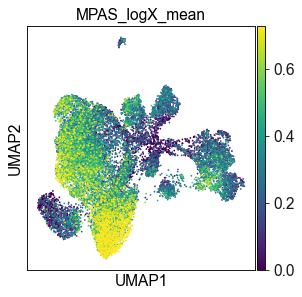

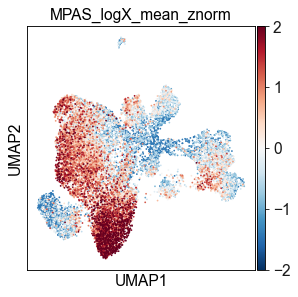

In [184]:
adata_sub.obs['MPAS_logX_mean'] = adata_sub[:,mapped_genes].layers['logX'].mean(axis=1)
adata_sub.obs['MPAS_logX_mean_znorm'] = scipy.stats.zscore(adata_sub.obs['MPAS_logX_mean'].values)
sc.pl.umap(adata_sub, color='MPAS_logX_mean', add_outline=False, vmin=0, vmax=get_vmax, cmap='viridis', ncols=4, s=10, save='_MRDs_MPAS_logX_mean.svg')
sc.pl.umap(adata_sub, color='MPAS_logX_mean_znorm', add_outline=False, vmin=-2, vmax=2, cmap='RdBu_r', ncols=4, s=10, save='_MRDs_MPAS_logX_mean_znorm.svg')

### Krt17+ MRD subset

In [185]:
adata_sub.obs['Krt17_status'] = ['Krt17+' if x>0 else 'Krt17-' for x in np.ravel(adata_sub[:,'Krt17'].layers['logX'])]

In [186]:
adata_sub = adata_sub[adata_sub.obs['Krt17_status'] == 'Krt17+'].copy()

In [187]:
adata_sub.obs['sample'].value_counts()

ERPMT_doxMRD        181
ERPMT_MRDrestart    176
ERPMT_3moMRD        166
ERPMT_osiMRD         81
Name: sample, dtype: int64

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Found 4936 highly variable genes
/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225//hvgs_scanpy_cellranger_batch_key_MRD_Krt17+_sample.png


computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


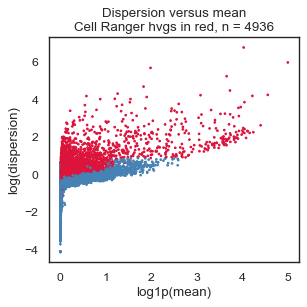

In [188]:
# Compute HVGs:
sns.set(style='white')
adata_sub.X = adata_sub.layers['X']

batch_key = 'sample'
sc.pp.highly_variable_genes(adata_sub, flavor='cell_ranger', batch_key=batch_key, n_bins=20, max_mean=np.inf)
colors_cell_ranger = [boolean_to_color[True] if x >0 else boolean_to_color[False]
                      for x in adata_sub.var['highly_variable']]
plt.scatter(np.log1p(adata_sub.var['means']), np.log(adata_sub.var['dispersions']),
            s=2, c=colors_cell_ranger)
plt.xlabel('log1p(mean)')
plt.ylabel('log(dispersion)')
n=sum(adata_sub.var["highly_variable"])
plt.title(f'Dispersion versus mean\nCell Ranger hvgs in red, n = {n}')
print(f'Found {n} highly variable genes')

fn = output_dir + f'/hvgs_scanpy_cellranger_batch_key_MRD_Krt17+_{batch_key}.png'
plt.tight_layout()
print(fn)
plt.savefig(fn, dpi=400)

# Compute PCA:
adata_sub.X =  adata_sub.layers['logX']
sc.pp.pca(adata_sub, n_comps=100)

/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225//PCA_linear_deviation_optimization.png
Linear Deviation Optimal PCs = 63


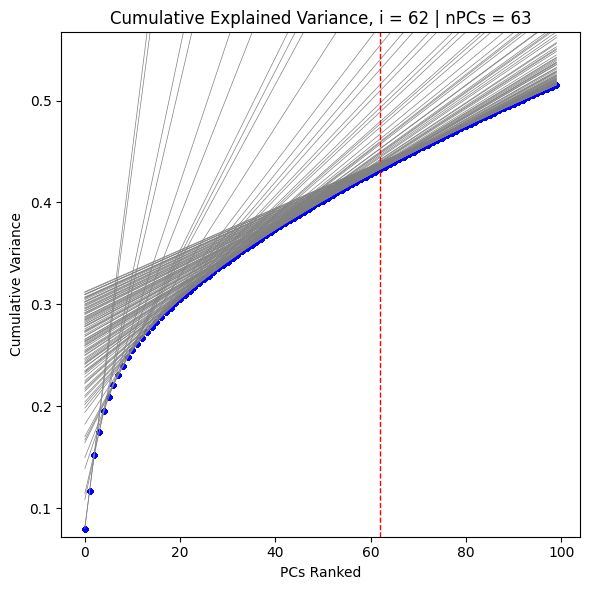

In [189]:
# Optimize for pRes

n = optimize_pcs(adata_sub, pca_name='pca', dev_thr=4e-6)
print(f'Linear Deviation Optimal PCs = {n}')

In [190]:
adata_sub.obsm[f'X_pca'] = adata_sub.obsm[f'X_pca'][:,:n]

In [191]:
adata_sub.obsm['X_pca'].shape

(604, 63)

In [192]:
sc.pp.neighbors(adata_sub, n_neighbors=30)

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 63
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [193]:
sc.tl.umap(adata_sub)

computing UMAP


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [194]:
sample_cmap = {'AT2_1mo': '#AD0404', 
               'ERPMT_pool': '#ff0000', 
               'ERPMT_doxMRD': '#E896D1', 
               'ERPMT_3moMRD': '#9012F1', 
               'transformed_SCLC': '#46A8FF', 
               'RPMT_pool': '#0432ff',
               'ERPMT_MRDrestart': '#d2b14c',
               'ERPMT_doxMRD': '#eca9e5',
               'ERPMT_osiMRD': '#a2df8d'}

adata_sub.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_sub.obs['sample'].unique())]

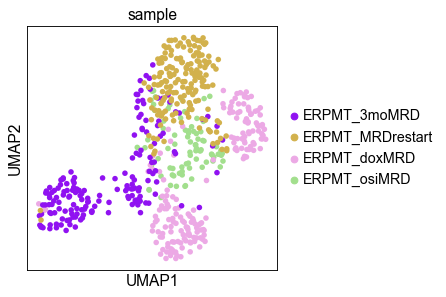

In [195]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300)

sc.pl.umap(adata_sub, color='sample', add_outline=False, s=100, save='_MRDs_Krt17_sub_sample.svg')

In [196]:
# Define functions for vmin and vmax of genes expression:

def get_vmin(values):
    p=0.05
    vmin=float(np.quantile(values, p))
    if vmin<=0:
        vmin=0
    return float(vmin)

def get_vmax(values):
    p=0.95
    vmax=float(np.quantile(values, p))
    if vmax<=0:
        vmax=0.1
    return float(vmax)

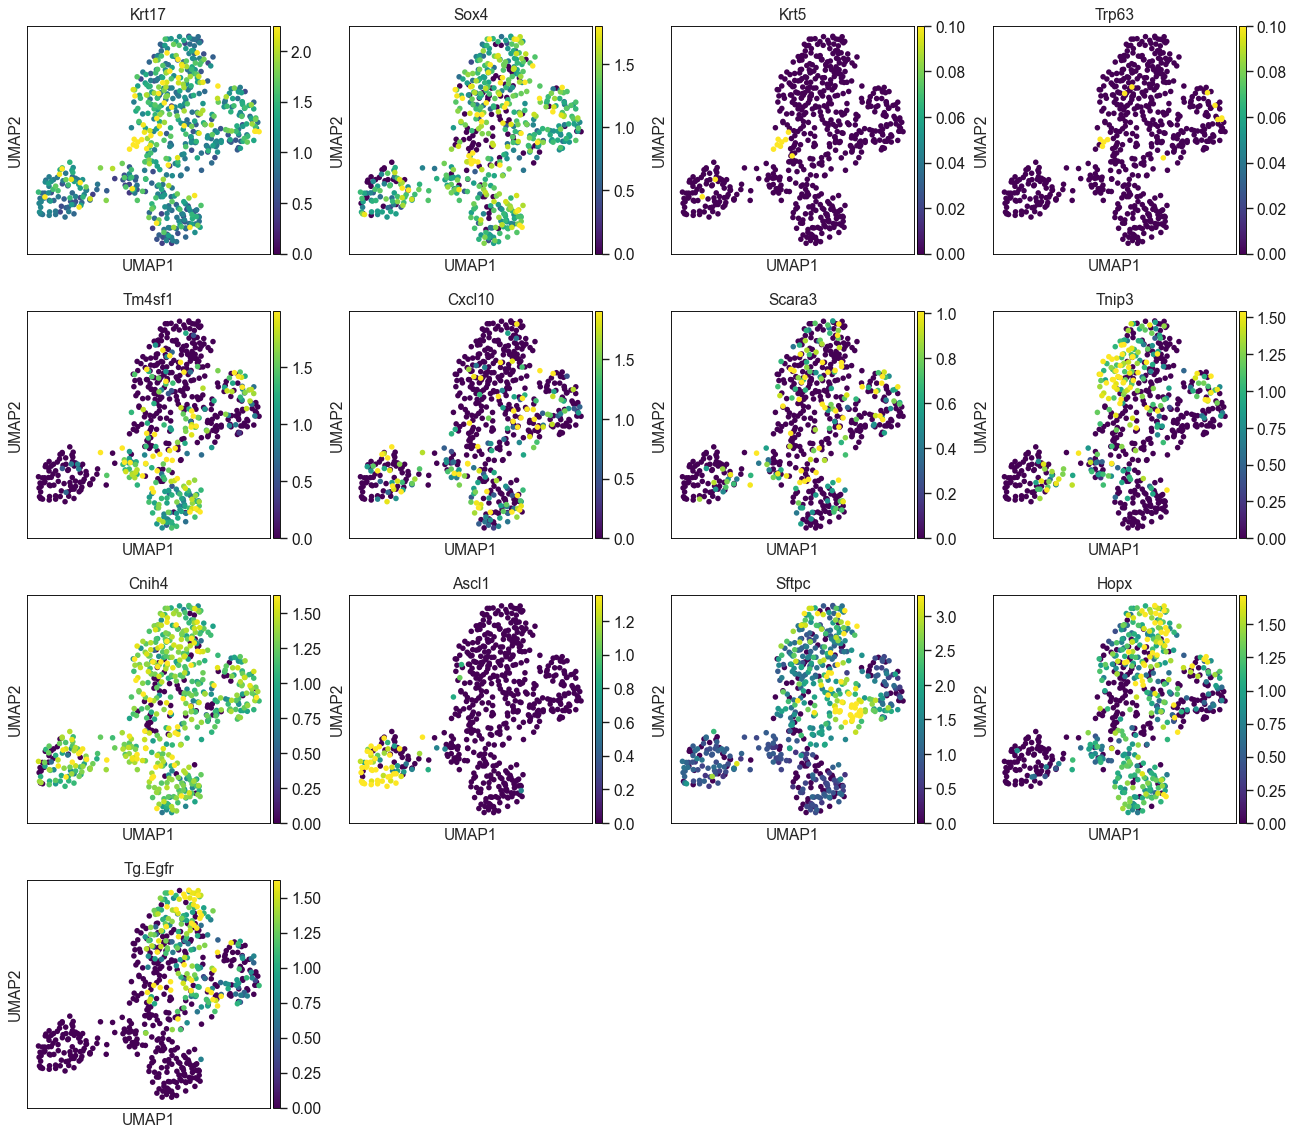

In [220]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300)

adata_sub.X = adata_sub.layers['logX']

#genes = ['Krt17', 'Cxcl10', 'Sftpc', 'Sox4', 'Scara3', 'Hopx', 'Krt5', 'Tnip3', 'Tg.Egfr', 'Tm4sf1', 'Cnih4', 'Ascl1']

genes = ['Krt17', 'Sox4', 'Krt5', 'Trp63',
         'Tm4sf1', 'Cxcl10', 'Scara3', 'Tnip3',
         'Cnih4', 'Ascl1', 'Sftpc', 'Hopx',
         'Tg.Egfr',]

#sc.pl.umap(adata_sub, color=genes, add_outline=False, vmin=0, vmax=get_vmax, cmap='viridis', ncols=4, s=10, save='_MRDs_select_genes.png')
sc.pl.umap(adata_sub, color=genes, add_outline=False, vmin=0, vmax=get_vmax, cmap='viridis', ncols=4, s=100, save='_MRDs_Krt17_sub_select_genes.svg')

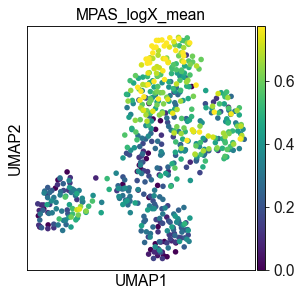

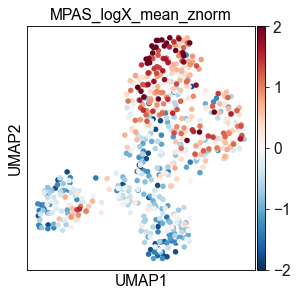

In [198]:
adata_sub.obs['MPAS_logX_mean'] = adata_sub[:,mapped_genes].layers['logX'].mean(axis=1)
adata_sub.obs['MPAS_logX_mean_znorm'] = scipy.stats.zscore(adata_sub.obs['MPAS_logX_mean'].values)
sc.pl.umap(adata_sub, color='MPAS_logX_mean', add_outline=False, vmin=0, vmax=get_vmax, cmap='viridis', ncols=4, s=100, save='_MRDs_MPAS_Krt17+_logX_mean.svg')
sc.pl.umap(adata_sub, color='MPAS_logX_mean_znorm', add_outline=False, vmin=-2, vmax=2, cmap='RdBu_r', ncols=4, s=100, save='_MRDs_MPAS_Krt17+_logX_mean_znorm.svg')